In [483]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **TASK1**

#**DIRTY DATA**

## **Documentation**



1.   **Data type Conversion**
  -  To improve the representation of loyalty status, the 'customerHasloyalty?' column was converted from integer to boolean data type.
   - To guarantee consistent date formatting, I changed the 'date' column to datetime data type, assuming mixed date formats with the day first.
   - To accurately represent time, the 'time' column was converted to datetime data type, and just the time portion was extracted.
2.   **Handling incorrect order types**

   - Taken out the 'time' column's hour, minute, and second.
   - Developed a function to ascertain the appropriate meal type depending on the order's timing.
   - By using the function on every row, a new column called "correct_order_type" was created.
   - To determine the wrong order types, the 'order_type' and the 'correct_order_type' were compared.
   - Where they differed, the 'correct_order_type' values were added to the 'order_type' column.


3. **Standardising branch codes**

  - From the 'branch_code' column, distinct branch codes were extracted.
   - In order to standardise branch codes (such as 'ns' to 'NS') a mapping dictionary was created.
   - To guarantee consistent branch code representation, the mapping was applied to the 'branch_code' column.
   - Using the valid branch codes from the 'branches' DataFrame as a guide, I filtered out rows that had invalid branch codes.


4. **Computing Item Prices and Updating Order Items**

  - To convert textual representations of lists into actual lists, an evaluation of the 'order_items' column was conducted.
   - Removed and classified unique items from every order.
   - Solved a linear least squares problem to determine the costs of individual items.
   - A dictionary mapping every item to the order type with the highest count was created.
   - A function was defined to update the item-order type mapping and item unit pricing in the "order_items" and "order_price" fields.
   - Updated the 'order_items' and 'order_price' columns for each row by applying the function.

5. **Correcting Customer Latitude and Longitude**

 - Created a function to exchange latitude and longitude data in case they were mismatched.
 - For uniformity, the latitude and longitude values were rounded to six decimal points.
 - Removed rows whose latitude and longitude values fell outside of the range that makes sense for the specified location (Melbourne).


6. **Updating distance_to_customer_km column**

  - Using the "edges" and "nodes" DataFrames, a graph was created.
  - Developed a function to use latitude and longitude to determine the closest node.
  - Using Dijkstra's method, determined the shortest path distance between the branch and customer nodes.
  - Added the computed distances to the 'distance_to_customer_KM' column.

7. **Handling anomalies in customerHasloyalty?**

   - Doubled the actual delivery fee to determine the expected complete delivery fee for loyal customers.
   - Made a comparison between the mean delivery fee and the expected complete delivery fee.
   - Highlighted rows in which the mean delivery fee was less than the expected complete delivery fee for loyal customers.
   - For the flagged rows, the 'customerHasloyalty?' column was updated to False.

These data cleaning procedures addressed a number of irregularities and problems with the quality of the data, transforming the unclean dataset into one that was cleaner and more consistent.






In [484]:
#Basic python libraries
import pandas as pd
import numpy as np
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [485]:
#Store the dirty data in a dataframe
dirtydata_60 = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/Group060_dirty_data.csv")

In [486]:
print(dirtydata_60.shape)
dirtydata_60.head(10)

(500, 12)


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03365,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 8), ('Shrimp', 2)]",501.00,-37.805576,144.944003,0,9.191,16.169450
1,ORDI00748,2018-12-23,19:49:51,Dinner,NS,"[('Salmon', 8), ('Fish&Chips', 5), ('Pasta', 9...",804.50,-37.821351,144.969579,0,8.752,16.886002
2,ORDX03810,2018-11-08,18:18:35,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 5), ('Pasta', 7)]",408.50,-37.814611,144.990406,0,5.417,11.443110
3,ORDI02381,2018-04-04,11:02:32,Breakfast,NS,"[('Eggs', 5), ('Pancake', 7)]",279.75,-37.813154,144.947786,0,9.991,14.985784
4,ORDY01165,2018-11-26,18:59:09,Dinner,TP,"[('Shrimp', 10), ('Fish&Chips', 4), ('Salmon',...",490.00,-37.806124,144.958304,0,9.078,13.149692
5,ORDI02298,2018-05-28,12:54:05,Lunch,NS,"[('Fries', 3), ('Steak', 2), ('Burger', 1), ('...",257.80,-37.793050,144.975720,1,8.186,13.479413
6,ORDI06037,2018-08-08,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 8), ('Steak', 10)]",659.60,-37.819012,144.960315,0,8.878,14.072151
7,ORDJ09281,2018-04-03,11:02:32,Breakfast,BK,"[('Eggs', 5), ('Coffee', 9), ('Cereal', 5), ('...",452.25,-37.812274,144.989074,0,9.890,12.542677
8,ORDJ08812,2018-07-31,14:55:46,Dinner,TP,"[('Steak', 10), ('Burger', 3), ('Chicken', 2),...",746.20,-37.809621,144.972322,0,9.104,12.650501
9,ORDI03318,2018-03-10,10:11:49,Breakfast,NS,"[('Cereal', 6), ('Coffee', 5), ('Pancake', 5)]",284.75,144.961877,-37.813865,0,8.249,15.706414


In [487]:
#Display datatypes of each column
dirtydata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [488]:
#Identify all distinct forms of date, e.g. 04-10-2018 (DD-MM-YYYY) and 2018-12-31 (YYYY-MM-DD)
print(dirtydata_60['date'].unique())

['2018-09-27' '2018-12-23' '2018-11-08' '2018-04-04' '2018-11-26'
 '2018-05-28' '2018-08-08' '2018-04-03' '2018-07-31' '2018-03-10'
 '2018-08-24' '02-09-2018' '2018-06-22' '2018-11-23' '2018-09-09'
 '2018-01-28' '2018-09-22' '2018-03-11' '2018-01-03' '2018-10-28'
 '2018-07-11' '02-11-2018' '04-10-2018' '2018-01-13' '2018-10-14'
 '02-10-2018' '2018-05-30' '2018-04-28' '2018-10-15' '2018-12-15'
 '2018-04-22' '2018-10-27' '2018-10-29' '2018-01-12' '2018-10-04'
 '2018-01-22' '2018-02-13' '2018-03-13' '2018-04-08' '2018-05-11'
 '2018-10-20' '2018-12-31' '2018-07-14' '2018-02-26' '2018-01-02'
 '2018-12-06' '2018-12-24' '2018-05-27' '2018-07-22' '2018-07-27'
 '2018-04-30' '2018-01-20' '2018-09-16' '2018-10-13' '2018-06-17'
 '2018-12-30' '2018-10-25' '2018-08-30' '2018-08-29' '2018-07-01'
 '2018-02-16' '2018-03-21' '2018-02-14' '2018-12-08' '2018-10-05'
 '2018-03-08' '2018-05-05' '2018-01-08' '2018-11-15' '2018-08-27'
 '2018-03-20' '07-12-2018' '2018-06-13' '2018-22-04' '2018-09-15'
 '2018-02-

In [489]:
# Converting the 'customerHasloyalty?' column to boolean data type
dirtydata_60['customerHasloyalty?'] = dirtydata_60['customerHasloyalty?'].astype(bool)
# Converting the 'date' column to datetime data type, assuming mixed date formats with the day first
dirtydata_60['date'] = pd.to_datetime(dirtydata_60['date'], format='mixed', dayfirst=True)
# Converting the 'time' column to datetime data type, extracting only the time part
dirtydata_60['time'] = pd.to_datetime(dirtydata_60['time'], format='%H:%M:%S').dt.time
dirtydata_60.info()
print(dirtydata_60['time'].head())
print(type(dirtydata_60['time'].iloc[0]))
print(dirtydata_60['date'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    bool          
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float

The time column's dtype remains object because datetime.time objects are not a native pandas dtype. Instead, they are stored as Python objects. Although the dtype shown in the info will still be object, the values will be of datetime.time type, suitable for time-based operations.

In [490]:
dirtydata_60.describe()

,date,order_price,customer_lat,customer_lon,distance_to_customer_KM,delivery_fee
count,500,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2018-07-02 09:50:24.000000256,485.309200,-30.753670,143.503195,8.705754,13.983344
min,2018-01-02 00:00:00,50.500000,-37.826303,-37.821724,3.724000,4.406027
25%,2018-04-01 18:00:00,274.887500,-37.818357,144.951862,7.664500,12.758699
50%,2018-07-02 00:00:00,439.100000,-37.811328,144.963079,8.666000,14.184261
75%,2018-09-28 06:00:00,648.425000,-37.803830,144.979250,9.780250,15.634642
max,2018-12-31 00:00:00,1422.500000,144.969443,145.019314,13.714000,22.112749
std,NaN,266.024861,25.335854,16.298767,1.652813,2.598052


Based on the provided data table, here are some observations:

The dataset contains 500 records, as indicated by the 'count' row.

The 'date' column shows that the data spans from 2018-01-02 00:00:00 to 2018-12-31 00:00:00, covering a full year.

The 'order_price' column has a wide range, with a minimum value of 50.500000 and a maximum value of 1422.500000. The mean order price is 485.309200.

The 'customer_lat' and 'customer_lon' columns suggest that the data is related to customer locations. The latitude values range from -37.826303 to 144.969443, and the longitude values range from -37.821724 to 145.019314.

The 'distance_to_customer_KM' column represents the distance to the customer in kilometers. It ranges from 3.724000 to 13.714000, with a mean of 8.705754.

The 'delivery_fee' column likely represents the fee charged for delivery. It ranges from 4.406027 to 22.112749, with a mean of 13.983344.

The standard deviation (std) values indicate the spread or dispersion of the data points from the mean. The 'order_price' and 'customer_lat' columns have relatively high standard deviations compared to the other columns.

The 25%, 50% (median), and 75% percentile values provide insights into the distribution of the data. For example, 25% of the order prices are below 274.687500, 50% are below 439.100000, and 75% are below 648.425000.

In [491]:
dirtydata_60.describe(include=['O'])

,order_id,time,order_type,branch_code,order_items
count,500,500,500,500,500
unique,500,72,3,6,495
top,ORDA03365,18:18:35,Breakfast,NS,"[('Fries', 4), ('Burger', 3)]"
freq,1,13,172,171,2


Based on the summary statistics, here are the key insights from the table:

The dataset contains 500 unique order IDs, as indicated by both the 'count' and 'unique' rows for the 'order_id' column.

The 'time' column has 72 unique values, suggesting that orders were placed at various times throughout the day.

There are 3 unique values in the 'order_type' column, indicating that orders can be categorized into 3 different types (Breakfast, Lunch and Dinner)

The 'branch_code' column has 6 unique values, suggesting that the orders are associated with 6 different branch locations (this is in incorrect as there are only 3 branches)

The 'order_items' column contains 495 unique combinations of items, indicating a wide variety of items ordered.

The most frequent (top) order ID is 'ORDA03365', which occurred 1 time in the dataset.

The most frequent 'time' value is '18:18:35', appearing 13 times in the dataset.

The most frequent 'order_type' is 'Breakfast', occurring 172 times.

The most frequent 'branch_code' is 'NS', appearing 171 times.

The most frequent combination of 'order_items' is "('Fries', 4), ('Burger', 3)", occurring 2 times.

In [492]:
import pandas as pd
branches_df = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/branches.csv')
unique_branch_codes = dirtydata_60['branch_code'].unique()
unique_branch_codes

array(['BK', 'NS', 'TP', 'ns', 'bk', 'tp'], dtype=object)

In [493]:
# Extracting the unique branch codes from the 'branches_df'
valid_branch_codes = branches_df['branch_code'].unique()

# Creating a mapping dictionary for branch codes
branch_code_mapping = {
    'ns': 'NS',
    'bk': 'BK',
    'tp': 'TP',
    'NS': 'NS',
    'BK': 'BK',
    'TP': 'TP'
}

dirtydata_60['branch_code'] = dirtydata_60['branch_code'].map(branch_code_mapping)

# Defining a function to check if a branch code is valid
def is_valid_branch_code(code):
    return code in valid_branch_codes

dirtydata_60.loc[:, 'is_valid_branch_code'] = dirtydata_60['branch_code'].apply(is_valid_branch_code)

dirtydata_60 = dirtydata_60[dirtydata_60['is_valid_branch_code']]

# Dropping the 'is_valid_branch_code' column as it is no longer needed
dirtydata_60 = dirtydata_60.drop('is_valid_branch_code', axis=1)

unique_corrected_branch_codes = dirtydata_60['branch_code'].unique()
unique_corrected_branch_codes

dirtydata_60.describe(include=['O'])


,order_id,time,order_type,branch_code,order_items
count,500,500,500,500,500
unique,500,72,3,3,495
top,ORDA03365,18:18:35,Breakfast,NS,"[('Fries', 4), ('Burger', 3)]"
freq,1,13,172,181,2


In [494]:
print(dirtydata_60['customerHasloyalty?'].dtype)

print(dirtydata_60['customerHasloyalty?'].value_counts())

bool
customerHasloyalty?
False    445
True      55
Name: count, dtype: int64


In [495]:
# Extracting hour, minute, and second from the 'time' column in the 'dirtydata_60' DataFrame
dirtydata_60['hour'] = pd.to_datetime(dirtydata_60['time'], format='%H:%M:%S').dt.hour
dirtydata_60['minute'] = pd.to_datetime(dirtydata_60['time'], format='%H:%M:%S').dt.minute
dirtydata_60['second'] = pd.to_datetime(dirtydata_60['time'], format='%H:%M:%S').dt.second

# Defining a function to determine the meal type based on the time of the order
def get_meal_type(row):
    hour = row['hour']
    minute = row['minute']
    second = row['second']

    if 8 <= hour < 12:
        return 'Breakfast'
    elif hour == 12 and minute == 0 and second == 0:
        return 'Breakfast'
    elif 12 < hour < 16 or (hour == 12 and (minute > 0 or second > 0)):
        return 'Lunch'
    elif hour == 16 and minute == 0 and second == 0:
        return 'Lunch'
    elif 16 < hour <= 20 or (hour == 16 and (minute > 0 or second > 0)):
        return 'Dinner'
    else:
        return 'Unknown'

dirtydata_60['correct_order_type'] = dirtydata_60.apply(get_meal_type, axis=1)
# Creating a new column to check if the 'order_type' matches the 'correct_order_type'
dirtydata_60['is_correct'] = dirtydata_60['order_type'] == dirtydata_60['correct_order_type']
correct_count = dirtydata_60['is_correct'].sum()
total_count = len(dirtydata_60)
# Printing the count of correct order types and the total number of orders
print(f"Count of correct order types: {correct_count} out of {total_count}")

Count of correct order types: 463 out of 500


In [496]:
dirtydata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    bool          
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
 12  hour                     500 non-nul

In [497]:
# Filtering the 'dirtydata_60' DataFrame to get rows where the order type is incorrect
incorrect_orders = dirtydata_60[dirtydata_60['is_correct'] == False]
print(incorrect_orders[['time', 'order_type']])

         time order_type
8    14:55:46     Dinner
23   08:20:16     Dinner
41   11:12:40     Dinner
61   20:00:00  Breakfast
83   16:27:02  Breakfast
86   16:16:54      Lunch
94   11:53:14      Lunch
116  13:44:47     Dinner
130  15:16:03     Dinner
139  15:05:54  Breakfast
167  18:38:52  Breakfast
171  14:55:46  Breakfast
204  16:37:10  Breakfast
209  09:00:50     Dinner
230  12:43:56  Breakfast
234  18:59:09  Breakfast
244  14:35:29     Dinner
250  15:46:28  Breakfast
251  14:45:38  Breakfast
255  13:04:13  Breakfast
260  15:26:11  Breakfast
264  09:21:07     Dinner
265  16:37:10      Lunch
270  16:27:02      Lunch
311  18:18:35  Breakfast
326  16:57:27  Breakfast
327  20:00:00      Lunch
332  12:13:31     Dinner
333  19:29:34  Breakfast
334  19:39:43      Lunch
358  14:35:29  Breakfast
380  15:36:20     Dinner
438  16:37:10  Breakfast
453  15:46:28     Dinner
471  16:37:10      Lunch
473  12:13:31     Dinner
481  12:43:56     Dinner


In [498]:
# Updating the 'order_type' column in the 'dirtydata_60' DataFrame where the current order type is incorrect
# This is done by setting the 'order_type' to the 'correct_order_type' for rows where they do not match
dirtydata_60.loc[dirtydata_60['order_type'] != dirtydata_60['correct_order_type'], 'order_type'] = dirtydata_60.loc[dirtydata_60['order_type'] != dirtydata_60['correct_order_type'], 'correct_order_type']

In [499]:
# Applying the 'get_meal_type' function to each row and checking if the 'order_type' matches the recalculated 'correct_order_type'
dirtydata_60['is_correct'] = dirtydata_60.apply(lambda row: row['order_type'] == get_meal_type(row), axis=1)

correct_count = dirtydata_60['is_correct'].sum()

total_count = len(dirtydata_60)
# Printing the count of correct order types and the total number of orders
print(f"Count of correct order types: {correct_count} out of {total_count}")

Count of correct order types: 500 out of 500


In [500]:
#Previously, order_id=ORDB09204 had an incorrect order_type = Breakfast for time = 16:27:02
#Lets check if it gets corrected
filtered_row = dirtydata_60[dirtydata_60['order_id'] == 'ORDB09204']
print(filtered_row)

     order_id       date      time order_type branch_code  \
83  ORDB09204 2018-09-15  16:27:02     Dinner          TP   

                                          order_items  order_price  \
83  [('Salmon', 7), ('Shrimp', 10), ('Fish&Chips',...        932.0   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
83    -37.815366    144.974639                False                    8.414   

    delivery_fee  hour  minute  second correct_order_type  is_correct  
83     13.808819    16      27       2             Dinner        True  


In [501]:
#Drop columns that are not required anymore
dirtydata_60.drop(['hour', 'minute', 'second', 'is_correct', 'correct_order_type'], axis=1, inplace=True)
dirtydata_60.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03365,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 8), ('Shrimp', 2)]",501.00,-37.805576,144.944003,False,9.191,16.169450
1,ORDI00748,2018-12-23,19:49:51,Dinner,NS,"[('Salmon', 8), ('Fish&Chips', 5), ('Pasta', 9...",804.50,-37.821351,144.969579,False,8.752,16.886002
2,ORDX03810,2018-11-08,18:18:35,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 5), ('Pasta', 7)]",408.50,-37.814611,144.990406,False,5.417,11.443110
3,ORDI02381,2018-04-04,11:02:32,Breakfast,NS,"[('Eggs', 5), ('Pancake', 7)]",279.75,-37.813154,144.947786,False,9.991,14.985784
4,ORDY01165,2018-11-26,18:59:09,Dinner,TP,"[('Shrimp', 10), ('Fish&Chips', 4), ('Salmon',...",490.00,-37.806124,144.958304,False,9.078,13.149692
5,ORDI02298,2018-05-28,12:54:05,Lunch,NS,"[('Fries', 3), ('Steak', 2), ('Burger', 1), ('...",257.80,-37.793050,144.975720,True,8.186,13.479413
6,ORDI06037,2018-08-08,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 8), ('Steak', 10)]",659.60,-37.819012,144.960315,False,8.878,14.072151
7,ORDJ09281,2018-04-03,11:02:32,Breakfast,BK,"[('Eggs', 5), ('Coffee', 9), ('Cereal', 5), ('...",452.25,-37.812274,144.989074,False,9.890,12.542677
8,ORDJ08812,2018-07-31,14:55:46,Lunch,TP,"[('Steak', 10), ('Burger', 3), ('Chicken', 2),...",746.20,-37.809621,144.972322,False,9.104,12.650501
9,ORDI03318,2018-03-10,10:11:49,Breakfast,NS,"[('Cereal', 6), ('Coffee', 5), ('Pancake', 5)]",284.75,144.961877,-37.813865,False,8.249,15.706414


In [502]:
# Evaluating the 'order_items' column to convert string representations of lists into actual lists
order_items = dirtydata_60['order_items'].apply(eval)

unique_items = set(item for order in order_items for item, _ in order)
print(unique_items)

{'Pancake', 'Pasta', 'Fish&Chips', 'Salmon', 'Chicken', 'Coffee', 'Cereal', 'Salad', 'Burger', 'Eggs', 'Shrimp', 'Steak', 'Fries'}


In [503]:
dirtydata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    bool          
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float

In [504]:
# Importing the ast module to safely evaluate string literals
import ast
# Converting the 'order_items' column from string representations of lists to actual lists using ast.literal_eval
order_items_list = [ast.literal_eval(items) for items in dirtydata_60['order_items']]

order_prices = dirtydata_60['order_price'].tolist()
# Extracting and sorting unique items from all orders
unique_items = sorted(set(item for order_items in order_items_list for item, _ in order_items))

# Initializing the matrix A with zeros, where each row represents an order and each column represents an item
A = np.zeros((len(order_items_list), len(unique_items)))
# Converting the order prices list to a numpy array b
b = np.array(order_prices)

# Populating the matrix A with quantities of each item in each order
for i, order_items in enumerate(order_items_list):
    for item, quantity in order_items:
        j = unique_items.index(item)
        A[i, j] = quantity

# Solving the linear least squares problem to find the prices of individual items
x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

for item, price in zip(unique_items, x):
    print(f"{item}: ${price:.2f}")

Burger: $27.21
Cereal: $18.46
Chicken: $30.91
Coffee: $8.80
Eggs: $23.67
Fish&Chips: $32.99
Fries: $10.82
Pancake: $23.09
Pasta: $32.33
Salad: $24.24
Salmon: $38.73
Shrimp: $48.85
Steak: $40.37


In [505]:
import re
# Extracting item names from the 'order_items' column using a regular expression and storing them in a new column 'items'
dirtydata_60['items'] = dirtydata_60['order_items'].str.findall(r"'(.*?)'")
# Exploding the 'items' column so that each item in a list gets its own row
dirtydata_exploded = dirtydata_60.explode('items')

item_counts = dirtydata_exploded.groupby(['order_type', 'items']).size().reset_index(name='count')

# Pivoting the item counts DataFrame to create a matrix with 'order_type' as rows and 'items' as columns

item_counts_pivot = item_counts.pivot(index='order_type', columns='items', values='count').fillna(0)
print("Item counts per order_type:")
print(item_counts_pivot)

Item counts per order_type:
items       Burger  Cereal  Chicken  Coffee   Eggs  Fish&Chips  Fries  \
order_type                                                              
Breakfast      3.0   116.0      1.0   114.0  122.0         1.0    2.0   
Dinner         5.0     1.0      0.0     0.0    1.0       118.0    1.0   
Lunch        106.0     1.0    113.0     2.0    0.0         2.0  122.0   

items       Pancake  Pasta  Salad  Salmon  Shrimp  Steak  
order_type                                                
Breakfast     113.0    1.0    0.0     1.0     1.0    3.0  
Dinner          2.0  132.0    4.0   122.0   119.0    0.0  
Lunch           1.0    2.0  113.0     1.0     1.0  115.0  


In [506]:
# Calculating the total counts of each item across all order types
total_counts = item_counts.groupby('items').agg({'count': 'sum'})
# Finding the order type with the maximum count for each item
max_order_type = item_counts.loc[item_counts.groupby('items')['count'].idxmax()]

updated_counts = max_order_type.copy()
updated_counts['count'] = total_counts['count'].values

# Pivoting the updated counts DataFrame to create a matrix with 'order_type' as rows and 'items' as columns
updated_item_counts_pivot = updated_counts.pivot(index='order_type', columns='items', values='count').fillna(0)


final_pivot = item_counts_pivot.copy()

# Updating the final pivot table to set counts to 0 for order types that do not have the maximum count for each item
for col in final_pivot.columns:
    max_index = updated_counts.set_index('items').loc[col, 'order_type']
    for index in final_pivot.index:
        if index != max_index:
            final_pivot.loc[index, col] = 0
        else:
            final_pivot.loc[index, col] = updated_item_counts_pivot.loc[max_index, col]
print("Updated Item counts per order_type:")
print(final_pivot)

Updated Item counts per order_type:
items       Burger  Cereal  Chicken  Coffee   Eggs  Fish&Chips  Fries  \
order_type                                                              
Breakfast      0.0   118.0      0.0   116.0  123.0         0.0    0.0   
Dinner         0.0     0.0      0.0     0.0    0.0       121.0    0.0   
Lunch        114.0     0.0    114.0     0.0    0.0         0.0  125.0   

items       Pancake  Pasta  Salad  Salmon  Shrimp  Steak  
order_type                                                
Breakfast     116.0    0.0    0.0     0.0     0.0    0.0  
Dinner          0.0  135.0    0.0   124.0   121.0    0.0  
Lunch           0.0    0.0  117.0     0.0     0.0  118.0  


In [507]:
# Creating a dictionary to map each item to the order type where it has the maximum count
item_order_type_map = {}
for item in final_pivot.columns:
    item_order_type_map[item] = final_pivot[item].idxmax()

item_unit_prices = dict(zip(unique_items, x))

def update_order_items_and_price(order_items, order_type):
    updated_items = []
    updated_price = 0

    items_list = re.findall(r"\'(.*?)\', (\d+)", order_items)
    for item_name, quantity in items_list:
      # Keeping only the items that belong to the given order type
        if item_order_type_map[item_name] == order_type:
            updated_items.append(f"('{item_name}', {quantity})")
            # Calculating the updated price based on the item unit price and quantity
            updated_price += item_unit_prices[item_name] * int(quantity)

    return "[" + ", ".join(updated_items) + "]", updated_price
# Applying the update_order_items_and_price function to each row of 'dirtydata_60' to update 'order_items' and 'order_price'
dirtydata_60[['order_items', 'order_price']] = dirtydata_60.apply(lambda x: pd.Series(update_order_items_and_price(x['order_items'], x['order_type'])), axis=1)

print("Top 10 rows of updated dirtydata_60:")
dirtydata_60.drop(['items'], axis=1, inplace=True)
dirtydata_60.head(40)

Top 10 rows of updated dirtydata_60:


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03365,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 8), ('Shrimp', 2)]",400.338743,-37.805576,144.944003,False,9.191,16.169450
1,ORDI00748,2018-12-23,19:49:51,Dinner,NS,"[('Salmon', 8), ('Fish&Chips', 5), ('Pasta', 9...",814.622779,-37.821351,144.969579,False,8.752,16.886002
2,ORDX03810,2018-11-08,18:18:35,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 5), ('Pasta', 7)]",430.009114,-37.814611,144.990406,False,5.417,11.443110
3,ORDI02381,2018-04-04,11:02:32,Breakfast,NS,"[('Eggs', 5), ('Pancake', 7)]",279.993532,-37.813154,144.947786,False,9.991,14.985784
4,ORDY01165,2018-11-26,18:59:09,Dinner,TP,"[('Shrimp', 10), ('Fish&Chips', 4), ('Salmon',...",930.303949,-37.806124,144.958304,False,9.078,13.149692
5,ORDI02298,2018-05-28,12:54:05,Lunch,NS,"[('Fries', 3), ('Steak', 2), ('Burger', 1), ('...",268.283047,-37.793050,144.975720,True,8.186,13.479413
6,ORDI06037,2018-08-08,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 8), ('Steak', 10)]",662.554791,-37.819012,144.960315,False,8.878,14.072151
7,ORDJ09281,2018-04-03,11:02:32,Breakfast,BK,"[('Eggs', 5), ('Coffee', 9), ('Cereal', 5), ('...",451.443747,-37.812274,144.989074,False,9.890,12.542677
8,ORDJ08812,2018-07-31,14:55:46,Lunch,TP,"[('Steak', 10), ('Burger', 3), ('Chicken', 2),...",725.060929,-37.809621,144.972322,False,9.104,12.650501
9,ORDI03318,2018-03-10,10:11:49,Breakfast,NS,"[('Cereal', 6), ('Coffee', 5), ('Pancake', 5)]",270.189370,144.961877,-37.813865,False,8.249,15.706414


In [508]:
dirtydata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    bool          
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float

In [509]:
def correct_lat_lon(row):
    if row['customer_lat'] > 144 and row['customer_lon'] < -37:
        # Swap if latitude is in longitude range and longitude is in latitude range
        lat, lon = row['customer_lon'], row['customer_lat']
    else:
        lat, lon = row['customer_lat'], row['customer_lon']
    return pd.Series([lat, lon])

# Apply the function to correct interchanged values
dirtydata_60[['customer_lat', 'customer_lon']] = dirtydata_60.apply(correct_lat_lon, axis=1)

dirtydata_60['customer_lat'] = dirtydata_60['customer_lat'].round(6)
dirtydata_60['customer_lon'] = dirtydata_60['customer_lon'].round(6)

dirtydata_60['customer_lat'] = dirtydata_60['customer_lat'].clip(lower=-38.0, upper=-37.5)
dirtydata_60['customer_lon'] = dirtydata_60['customer_lon'].clip(lower=144.5, upper=145.5)

dirtydata_60.head(40)
dirtydata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    bool          
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float

In [510]:
import networkx as nx

edges = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/edges.csv')
nodes = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/nodes.csv')

# Create the graph
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['u'], row['v'], distance=row['distance(m)'])

# Function to find the nearest node
def find_nearest_node(lat, lon):
    nodes['distance'] = np.sqrt((nodes['lat'] - lat)**2 + (nodes['lon'] - lon)**2)
    nearest_node = nodes.loc[nodes['distance'].idxmin(), 'node']
    return nearest_node

# Initialize new column for calculated distances
dirtydata_60['distance_to_customer_KM_calculated'] = np.nan

# Calculate distances for all rows
for idx, row in dirtydata_60.iterrows():
    branch_node = find_nearest_node(branches_df.loc[branches_df['branch_code'] == row['branch_code'], 'branch_lat'].values[0],
                                    branches_df.loc[branches_df['branch_code'] == row['branch_code'], 'branch_lon'].values[0])
    customer_node = find_nearest_node(row['customer_lat'], row['customer_lon'])
    try:
        # Calculate the shortest path using Dijkstra's algorithm
        distance_meters = nx.dijkstra_path_length(G, source=branch_node, target=customer_node, weight='distance')
        dirtydata_60.at[idx, 'distance_to_customer_KM_calculated'] = distance_meters / 1000  # Convert meters to kilometers
    except nx.NetworkXNoPath:
        dirtydata_60.at[idx, 'distance_to_customer_KM_calculated'] = np.nan  # Return NaN if no path exists

# Compare the two columns
comparison_df = dirtydata_60[['distance_to_customer_KM', 'distance_to_customer_KM_calculated']]
print(comparison_df.head(40))


    distance_to_customer_KM  distance_to_customer_KM_calculated
0                     9.191                               9.191
1                     8.752                               8.752
2                     5.417                               5.417
3                     9.991                               9.991
4                     9.078                               9.078
5                     8.186                               8.186
6                     8.878                               8.878
7                     9.890                               5.311
8                     9.104                               9.104
9                     8.249                               8.249
10                    7.743                               7.743
11                    7.724                               7.724
12                    7.636                               7.636
13                   11.598                              11.598
14                    5.823             

In [511]:
# Replace values in distance_to_customer_KM with distance_to_customer_KM_calculated
dirtydata_60['distance_to_customer_KM'] = dirtydata_60['distance_to_customer_KM_calculated']

# Drop the distance_to_customer_KM_calculated column
dirtydata_60.drop(columns=['distance_to_customer_KM_calculated'], inplace=True)

# Display the updated dataframe
dirtydata_60.head(40)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03365,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 8), ('Shrimp', 2)]",400.338743,-37.805576,144.944003,False,9.191,16.169450
1,ORDI00748,2018-12-23,19:49:51,Dinner,NS,"[('Salmon', 8), ('Fish&Chips', 5), ('Pasta', 9...",814.622779,-37.821350,144.969579,False,8.752,16.886002
2,ORDX03810,2018-11-08,18:18:35,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 5), ('Pasta', 7)]",430.009114,-37.814611,144.990406,False,5.417,11.443110
3,ORDI02381,2018-04-04,11:02:32,Breakfast,NS,"[('Eggs', 5), ('Pancake', 7)]",279.993532,-37.813154,144.947786,False,9.991,14.985784
4,ORDY01165,2018-11-26,18:59:09,Dinner,TP,"[('Shrimp', 10), ('Fish&Chips', 4), ('Salmon',...",930.303949,-37.806124,144.958304,False,9.078,13.149692
5,ORDI02298,2018-05-28,12:54:05,Lunch,NS,"[('Fries', 3), ('Steak', 2), ('Burger', 1), ('...",268.283047,-37.793050,144.975720,True,8.186,13.479413
6,ORDI06037,2018-08-08,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 8), ('Steak', 10)]",662.554791,-37.819012,144.960315,False,8.878,14.072151
7,ORDJ09281,2018-04-03,11:02:32,Breakfast,BK,"[('Eggs', 5), ('Coffee', 9), ('Cereal', 5), ('...",451.443747,-37.812274,144.989074,False,5.311,12.542677
8,ORDJ08812,2018-07-31,14:55:46,Lunch,TP,"[('Steak', 10), ('Burger', 3), ('Chicken', 2),...",725.060929,-37.809621,144.972322,False,9.104,12.650501
9,ORDI03318,2018-03-10,10:11:49,Breakfast,NS,"[('Cereal', 6), ('Coffee', 5), ('Pancake', 5)]",270.189370,-37.813865,144.961877,False,8.249,15.706414


In [512]:
dirtydata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    bool          
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float

In [513]:
print(dirtydata_60['customerHasloyalty?'].value_counts())

customerHasloyalty?
False    445
True      55
Name: count, dtype: int64


In [514]:
# Calculate the expected full delivery fee for loyal customers
dirtydata_60['expected_full_delivery_fee'] = dirtydata_60.apply(
    lambda row: row['delivery_fee'] * 2 if row['customerHasloyalty?'] else row['delivery_fee'],
    axis=1
)

# Compare the expected full delivery fee with the actual delivery fee for loyal customers
loyal_customers = dirtydata_60[dirtydata_60['customerHasloyalty?']]
print(loyal_customers[['delivery_fee', 'expected_full_delivery_fee']])

# Calculate the length of the expected_full_delivery_fee column for loyal customers
length_expected_full_delivery_fee = len(loyal_customers['expected_full_delivery_fee'])

length_expected_full_delivery_fee


     delivery_fee  expected_full_delivery_fee
5       13.479413                   26.958827
14      14.678840                   29.357681
18       7.347990                   14.695979
23       7.056307                   14.112613
36       4.816393                    9.632787
48       6.406560                   12.813120
51      13.224134                   26.448269
71      11.988138                   23.976276
87      13.629524                   27.259048
92       7.136090                   14.272180
99       6.902024                   13.804047
113      8.415600                   16.831199
114     14.010402                   28.020804
124     15.112791                   30.225582
137     15.183324                   30.366648
148      7.712179                   15.424358
153     16.386298                   32.772595
175     14.624234                   29.248469
189     16.924189                   33.848378
193      6.345267                   12.690535
206      6.816575                 

55

In [515]:
# Calculate the mean of the delivery_fee column
mean_delivery_fee = dirtydata_60['delivery_fee'].mean()

# Add a column to flag rows where expected_full_delivery_fee is more than the mean of the delivery_fee column
dirtydata_60['flag_expected_fee_above_mean'] = dirtydata_60.apply(
    lambda row: 'Yes' if row['customerHasloyalty?'] and row['expected_full_delivery_fee'] > mean_delivery_fee else 'No',
    axis=1
)

# Filter to show only the flagged rows
flagged_rows_above_mean = dirtydata_60[dirtydata_60['flag_expected_fee_above_mean'] == 'Yes']

print(flagged_rows_above_mean[['order_id', 'branch_code', 'customerHasloyalty?', 'delivery_fee', 'expected_full_delivery_fee']])

length_flagged_rows_above_mean = len(flagged_rows_above_mean)

length_flagged_rows_above_mean

      order_id branch_code  customerHasloyalty?  delivery_fee  \
5    ORDI02298          NS                 True     13.479413   
14   ORDX08215          BK                 True     14.678840   
18   ORDK00849          BK                 True      7.347990   
23   ORDY11041          TP                 True      7.056307   
51   ORDY09236          TP                 True     13.224134   
71   ORDC05773          NS                 True     11.988138   
87   ORDK02524          BK                 True     13.629524   
92   ORDB07956          TP                 True      7.136090   
113  ORDX02132          BK                 True      8.415600   
114  ORDY10034          TP                 True     14.010402   
124  ORDI08138          NS                 True     15.112791   
137  ORDK07760          BK                 True     15.183324   
148  ORDX05304          BK                 True      7.712179   
153  ORDC05654          NS                 True     16.386298   
175  ORDA03907          B

39

In [516]:
dirtydata_60.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,expected_full_delivery_fee,flag_expected_fee_above_mean
0,ORDA03365,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 8), ('Shrimp', 2)]",400.338743,-37.805576,144.944003,False,9.191,16.169450,16.169450,No
1,ORDI00748,2018-12-23,19:49:51,Dinner,NS,"[('Salmon', 8), ('Fish&Chips', 5), ('Pasta', 9...",814.622779,-37.821350,144.969579,False,8.752,16.886002,16.886002,No
2,ORDX03810,2018-11-08,18:18:35,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 5), ('Pasta', 7)]",430.009114,-37.814611,144.990406,False,5.417,11.443110,11.443110,No
3,ORDI02381,2018-04-04,11:02:32,Breakfast,NS,"[('Eggs', 5), ('Pancake', 7)]",279.993532,-37.813154,144.947786,False,9.991,14.985784,14.985784,No
4,ORDY01165,2018-11-26,18:59:09,Dinner,TP,"[('Shrimp', 10), ('Fish&Chips', 4), ('Salmon',...",930.303949,-37.806124,144.958304,False,9.078,13.149692,13.149692,No
5,ORDI02298,2018-05-28,12:54:05,Lunch,NS,"[('Fries', 3), ('Steak', 2), ('Burger', 1), ('...",268.283047,-37.793050,144.975720,True,8.186,13.479413,26.958827,Yes
6,ORDI06037,2018-08-08,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 8), ('Steak', 10)]",662.554791,-37.819012,144.960315,False,8.878,14.072151,14.072151,No
7,ORDJ09281,2018-04-03,11:02:32,Breakfast,BK,"[('Eggs', 5), ('Coffee', 9), ('Cereal', 5), ('...",451.443747,-37.812274,144.989074,False,5.311,12.542677,12.542677,No
8,ORDJ08812,2018-07-31,14:55:46,Lunch,TP,"[('Steak', 10), ('Burger', 3), ('Chicken', 2),...",725.060929,-37.809621,144.972322,False,9.104,12.650501,12.650501,No
9,ORDI03318,2018-03-10,10:11:49,Breakfast,NS,"[('Cereal', 6), ('Coffee', 5), ('Pancake', 5)]",270.189370,-37.813865,144.961877,False,8.249,15.706414,15.706414,No


In [517]:
dirtydata_60.loc[dirtydata_60['flag_expected_fee_above_mean'] == 'Yes', 'customerHasloyalty?'] = False
dirtydata_60.drop(columns=['flag_expected_fee_above_mean'], inplace=True)
dirtydata_60.head(10)
print(dirtydata_60['customerHasloyalty?'].value_counts())

customerHasloyalty?
False    484
True      16
Name: count, dtype: int64


In [518]:
dirtydata_60.drop(columns=['expected_full_delivery_fee'], inplace=True)
dirtydata_60.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03365,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 8), ('Shrimp', 2)]",400.338743,-37.805576,144.944003,False,9.191,16.169450
1,ORDI00748,2018-12-23,19:49:51,Dinner,NS,"[('Salmon', 8), ('Fish&Chips', 5), ('Pasta', 9...",814.622779,-37.821350,144.969579,False,8.752,16.886002
2,ORDX03810,2018-11-08,18:18:35,Dinner,BK,"[('Salmon', 1), ('Fish&Chips', 5), ('Pasta', 7)]",430.009114,-37.814611,144.990406,False,5.417,11.443110
3,ORDI02381,2018-04-04,11:02:32,Breakfast,NS,"[('Eggs', 5), ('Pancake', 7)]",279.993532,-37.813154,144.947786,False,9.991,14.985784
4,ORDY01165,2018-11-26,18:59:09,Dinner,TP,"[('Shrimp', 10), ('Fish&Chips', 4), ('Salmon',...",930.303949,-37.806124,144.958304,False,9.078,13.149692
5,ORDI02298,2018-05-28,12:54:05,Lunch,NS,"[('Fries', 3), ('Steak', 2), ('Burger', 1), ('...",268.283047,-37.793050,144.975720,False,8.186,13.479413
6,ORDI06037,2018-08-08,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 8), ('Steak', 10)]",662.554791,-37.819012,144.960315,False,8.878,14.072151
7,ORDJ09281,2018-04-03,11:02:32,Breakfast,BK,"[('Eggs', 5), ('Coffee', 9), ('Cereal', 5), ('...",451.443747,-37.812274,144.989074,False,5.311,12.542677
8,ORDJ08812,2018-07-31,14:55:46,Lunch,TP,"[('Steak', 10), ('Burger', 3), ('Chicken', 2),...",725.060929,-37.809621,144.972322,False,9.104,12.650501
9,ORDI03318,2018-03-10,10:11:49,Breakfast,NS,"[('Cereal', 6), ('Coffee', 5), ('Pancake', 5)]",270.189370,-37.813865,144.961877,False,8.249,15.706414


#2

# **MISSING DATA**

In [519]:
dirtydata_60.to_csv("60_dirty_data_solution.csv", index=False)

In [520]:
#Importing
import pandas as pd
import numpy as np
import networkx as nx
from math import radians
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Explaining flow of Missing Data in the Dataset-

###1.  Data Loading and Initial Analysis:

Datasets related to missing data , branches, edges, and nodes were loaded.
then examining their structure and summary statistics to understand the nature of the missing values.

###2.  Identification of Missing Values:

Identified columns with missing data are-
'branch_code', 'distance_to_customer_KM', and 'delivery_fee'.
The total count of missing values was assessed to determine the extent of data imputation needed.


###3.We thought of making a linear regression model to predicted the missing values of delivery_fee column.So for that we first need to fix the values of the missing columns.which means imputation in branchcode and distance columns.

- Imputation Strategy for Branch Codes:

  Extracted prefixes from 'order_id' which indicated potential relationships with 'branch_code'.Mapped these prefixes to the most common 'branch_code' observed with similar prefixes then filling missing 'branch_code' entries using this mapping.

- Distance Calculation Using Graph Theory:
  For missing 'distance_to_customer_KM', constructed a graph from 'edges' data.
  Implemented Dijkstra's algorithm to compute the shortest path between restaurant branches and customer locations based on the nearest nodes.


4. Handling Missing Delivery Fees:
Applied predictive modeling techniques to estimate missing 'delivery_fee' values.

Created features from existing data and used a regression model trained on entries with known delivery fees.
The model used included preprocessing steps such as scaling and encoding.

5. Validation and Accuracy Checks:
Evaluated the regression model using metrics R-squared to check the performance in predicting delivery fees.

In [521]:
# Loading data
edges = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/edges.csv')
nodes = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/nodes.csv')
missdata_60 = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/Group060_missing_data.csv')
branches = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/branches.csv')

In [522]:
print("Missing data \n",missdata_60.head())
print("branches data \n",missdata_60.head())
print("nodes data \n",missdata_60.head())
print("edges data \n",missdata_60.head())


Missing data 
     order_id        date      time order_type branch_code  \
0  ORDX05422  2018-06-17  13:24:30      Lunch          BK   
1  ORDA03471  2018-10-30  17:58:18     Dinner          BK   
2  ORDZ06892  2018-06-01  12:54:05      Lunch         NaN   
3  ORDJ06269  2018-01-23  08:40:33  Breakfast          TP   
4  ORDZ01417  2018-10-29  17:58:18     Dinner          NS   

                                         order_items  order_price  \
0  [('Fries', 6), ('Burger', 6), ('Salad', 10), (...        610.0   
1  [('Salmon', 10), ('Shrimp', 8), ('Pasta', 7), ...       1139.5   
2                      [('Steak', 3), ('Burger', 8)]        383.0   
3  [('Coffee', 3), ('Pancake', 4), ('Cereal', 2),...        249.5   
4                      [('Pasta', 4), ('Shrimp', 6)]        434.0   

   customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
0    -37.802166    144.964518                    0                    7.721   
1    -37.801220    144.963020                

In [523]:
#checking the total count for missing values
missdata_60.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
dtype: int64

In [524]:
missdata_60.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,450.000000,450.000000
mean,494.325100,-37.812189,144.965904,0.038000,8.895684,14.106813
std,266.662092,0.007818,0.021063,0.191388,1.577199,2.297224
min,31.750000,-37.835050,144.916005,0.000000,3.650000,5.209894
25%,286.875000,-37.818810,144.952142,0.000000,7.860000,13.006645
50%,446.700000,-37.812902,144.963904,0.000000,8.911500,14.334678
75%,656.750000,-37.805407,144.978492,0.000000,9.855250,15.491289
max,1416.500000,-37.789103,145.026637,1.000000,13.773000,19.403301


# fixing branch code column

Some patterns in order id column has found so we are made a mapping to fix the branch code column.

In [525]:
# Extracting prefixes from 'order_id'
missdata_60['order_prefix'] = missdata_60['order_id'].str.extract(r'([A-Z]+)')

# Analyze the relationship between extracted prefix and branch_code
prefix_branch_mapping = missdata_60.groupby('order_prefix')['branch_code'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'No Mode Found')
# Display the mapping and count of each prefix
prefix_branch_mapping, missdata_60['order_prefix'].value_counts()

(order_prefix
 ORDA    BK
 ORDB    TP
 ORDC    NS
 ORDI    NS
 ORDJ    TP
 ORDK    BK
 ORDX    BK
 ORDY    TP
 ORDZ    NS
 Name: branch_code, dtype: object,
 order_prefix
 ORDA    69
 ORDC    65
 ORDX    59
 ORDZ    57
 ORDJ    54
 ORDK    53
 ORDI    49
 ORDY    48
 ORDB    46
 Name: count, dtype: int64)

In [526]:
# Mapping based on the analysis
prefix_to_branch = {
    'ORDA': 'BK', 'ORDK': 'BK', 'ORDX': 'BK',
    'ORDJ': 'TP', 'ORDB': 'TP', 'ORDY': 'TP',
    'ORDC': 'NS', 'ORDI': 'NS', 'ORDZ': 'NS'
}

# Creating  new column for all entries based on the prefix mapping
missdata_60['full_predicted_branch_code'] = missdata_60['order_prefix'].map(prefix_to_branch)


# Fill missing values in 'branch_code' using the 'full_predicted_branch_code'
missdata_60['branch_code'].fillna(missdata_60['full_predicted_branch_code'], inplace=True)
# Verify that there are no more missing values in 'branch_code'
missing_after_imputation = missdata_60['branch_code'].isnull().sum()
missdata_60.head(), missing_after_imputation


(    order_id        date      time order_type branch_code  \
 0  ORDX05422  2018-06-17  13:24:30      Lunch          BK   
 1  ORDA03471  2018-10-30  17:58:18     Dinner          BK   
 2  ORDZ06892  2018-06-01  12:54:05      Lunch          NS   
 3  ORDJ06269  2018-01-23  08:40:33  Breakfast          TP   
 4  ORDZ01417  2018-10-29  17:58:18     Dinner          NS   
 
                                          order_items  order_price  \
 0  [('Fries', 6), ('Burger', 6), ('Salad', 10), (...        610.0   
 1  [('Salmon', 10), ('Shrimp', 8), ('Pasta', 7), ...       1139.5   
 2                      [('Steak', 3), ('Burger', 8)]        383.0   
 3  [('Coffee', 3), ('Pancake', 4), ('Cereal', 2),...        249.5   
 4                      [('Pasta', 4), ('Shrimp', 6)]        434.0   
 
    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
 0    -37.802166    144.964518                    0                    7.721   
 1    -37.801220    144.963020              

## missing values in branch code column is being imputed



In [527]:
missdata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     450 non-null    float64
 11  delivery_fee                450 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

# Implementing missing values in distance_to_customer_KM column

### STEP1-Merging branches file and missing data file on the base of 'branch_code' column which we imputed above.

In [528]:
# Merge branch location data into the orders DataFrame
missdata_60 = missdata_60.merge(branches[['branch_code', 'branch_lat', 'branch_lon']], on='branch_code', how='left')
missdata_60.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,order_prefix,full_predicted_branch_code,branch_lat,branch_lon
0,ORDX05422,2018-06-17,13:24:30,Lunch,BK,"[('Fries', 6), ('Burger', 6), ('Salad', 10), (...",610.0,-37.802166,144.964518,0,7.721,NaN,ORDX,BK,-37.815834,145.046450
1,ORDA03471,2018-10-30,17:58:18,Dinner,BK,"[('Salmon', 10), ('Shrimp', 8), ('Pasta', 7), ...",1139.5,-37.801220,144.963020,0,8.061,14.950290,ORDA,BK,-37.815834,145.046450
2,ORDZ06892,2018-06-01,12:54:05,Lunch,NS,"[('Steak', 3), ('Burger', 8)]",383.0,-37.820953,144.947581,0,9.811,15.355152,ORDZ,NS,-37.773803,144.983647
3,ORDJ06269,2018-01-23,08:40:33,Breakfast,TP,"[('Coffee', 3), ('Pancake', 4), ('Cereal', 2),...",249.5,-37.798917,144.935682,0,11.325,13.543142,ORDJ,TP,-37.861835,144.905716
4,ORDZ01417,2018-10-29,17:58:18,Dinner,NS,"[('Pasta', 4), ('Shrimp', 6)]",434.0,-37.808045,144.973359,0,7.111,12.972792,ORDZ,NS,-37.773803,144.983647


### step 2 using the Djikstra algorithm to calculate the shortest distance between customer and restaurant.

This function -'calculate_distance' calculates the distance between branches and customers using Dijkstra's algorithm, but only for rows where the distance_to_customer_KM value is missing (NaN).
working-it finds the nearest branch node and customer node using the find_nearest_node function.
It then calculates the shortest path distance between these two nodes using Dijkstra's algorithm, converting the distance from meters to kilometers.
If no path exists between the nodes, it returns NaN.
If the distance is not NaN, it returns the existing distance.

In [529]:
# Create the graph
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['u'], row['v'], distance=row['distance(m)'])

# Function to find the nearest node
def find_nearest_node(lat, lon):
    nodes['distance'] = np.sqrt((nodes['lat'] - lat)**2 + (nodes['lon'] - lon)**2)
    nearest_node = nodes.loc[nodes['distance'].idxmin(), 'node']
    return nearest_node

# Calculate distances between branches and customers only for missing distance values
def calculate_distance(row):
    if pd.isna(row['distance_to_customer_KM']):  # Check if the distance is NaN
        branch_node = find_nearest_node(row['branch_lat'], row['branch_lon'])
        customer_node = find_nearest_node(row['customer_lat'], row['customer_lon'])
        try:
            # Calculate the shortest path using Dijkstra's algorithm
            distance_meters = nx.dijkstra_path_length(G, source=branch_node, target=customer_node, weight='distance')
            return distance_meters / 1000  # Convert meters to kilometers
        except nx.NetworkXNoPath:
            return np.nan  # Return NaN if no path exists
    else:
        return row['distance_to_customer_KM']  # Return the existing distance if it's not NaN

# Apply the function to calculate distances where needed
missdata_60['calculated_distance'] = missdata_60.apply(calculate_distance, axis=1)
print(missdata_60.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     450 non-null    float64
 11  delivery_fee                450 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

# Fill missing values in 'distance_to_customer_KM'

In [530]:
# Fill missing values in 'distance_to_customer_KM' using 'calculated_distance'
missdata_60['distance_to_customer_KM'].fillna(missdata_60['calculated_distance'], inplace=True)
print(missdata_60.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     500 non-null    float64
 11  delivery_fee                450 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

# Missing values in distance_to_customer_KM column is being imputed

In [531]:
# Check the info to confirm no more missing values in 'distance_to_customer_KM'
print(missdata_60['distance_to_customer_KM'].isnull().sum())


0


#**Making a linear regression model to predict the delivery fee column**

*  Model Preparation and Feature Engineering:
- As in instructions we are given that delevery fee depends on
  * a. weekend or weekday (1 or 0) - as a continuous variable
  * b. time of the day (morning 0, afternoon 1, evening 2) - as a continuous variable
  * c. distance between branch and customer
  
    - so by consider these points we are getting 'time of day' from time column,'weekday or weekend' from date column.

  *  Also it is given that the loyality custiomer has 50 percent discount so creating new column which will keep original delivery fee for the every customer.


 Model Setup:
 * Preprocessors for scaling numerical features and encoding categorical features.Linear Regression as the modeling technique and target variable was the adjusted delivery fee.
 * Training model on data where delivery fees were known then evaluated the model using R-squared and Mean Squared Error (MSE) metrics.

 * Feature Importance and Selection:Recursive Feature Elimination (RFE) was used to refine the model by selecting the most impactful features tehn refitted the model using only the selected features to optimize performance.



In [532]:
# Feature Engineering
def get_time_of_day(hour):
    if hour < 12:
        return 0  # Morning
    elif 12 <= hour < 18:
        return 1  # Afternoon
    else:
        return 2  # Evening

missdata_60['time_of_day'] = pd.to_datetime(missdata_60['time']).dt.hour.apply(get_time_of_day)
missdata_60['weekday'] = pd.to_datetime(missdata_60['date']).dt.weekday
missdata_60['weekend'] = missdata_60['weekday'].apply(lambda x: 1 if x >= 5 else 0)
missdata_60['delivery_fee_adjusted'] = missdata_60.apply(lambda row: row['delivery_fee'] * 2 if row['customerHasloyalty?'] == 1 else row['delivery_fee'], axis=1)
missdata_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     500 non-null    float64
 11  delivery_fee                450 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

<ipython-input-532-26424ac35b56>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  missdata_60['time_of_day'] = pd.to_datetime(missdata_60['time']).dt.hour.apply(get_time_of_day)


In [533]:
missdata_60.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,...,delivery_fee,order_prefix,full_predicted_branch_code,branch_lat,branch_lon,calculated_distance,time_of_day,weekday,weekend,delivery_fee_adjusted
0,ORDX05422,2018-06-17,13:24:30,Lunch,BK,"[('Fries', 6), ('Burger', 6), ('Salad', 10), (...",610.00,-37.802166,144.964518,0,...,NaN,ORDX,BK,-37.815834,145.046450,7.721,1,6,1,NaN
1,ORDA03471,2018-10-30,17:58:18,Dinner,BK,"[('Salmon', 10), ('Shrimp', 8), ('Pasta', 7), ...",1139.50,-37.801220,144.963020,0,...,14.950290,ORDA,BK,-37.815834,145.046450,8.061,1,1,0,14.950290
2,ORDZ06892,2018-06-01,12:54:05,Lunch,NS,"[('Steak', 3), ('Burger', 8)]",383.00,-37.820953,144.947581,0,...,15.355152,ORDZ,NS,-37.773803,144.983647,9.811,1,4,0,15.355152
3,ORDJ06269,2018-01-23,08:40:33,Breakfast,TP,"[('Coffee', 3), ('Pancake', 4), ('Cereal', 2),...",249.50,-37.798917,144.935682,0,...,13.543142,ORDJ,TP,-37.861835,144.905716,11.325,0,1,0,13.543142
4,ORDZ01417,2018-10-29,17:58:18,Dinner,NS,"[('Pasta', 4), ('Shrimp', 6)]",434.00,-37.808045,144.973359,0,...,12.972792,ORDZ,NS,-37.773803,144.983647,7.111,1,0,0,12.972792
5,ORDJ03771,2018-02-26,09:51:32,Breakfast,TP,"[('Pancake', 1), ('Coffee', 1)]",31.75,-37.807228,144.996662,0,...,13.440500,ORDJ,TP,-37.861835,144.905716,11.002,0,0,0,13.440500
6,ORDJ02618,2018-06-22,13:44:47,Lunch,TP,"[('Fries', 2), ('Salad', 6)]",127.20,-37.803468,144.962735,0,...,12.399563,ORDJ,TP,-37.861835,144.905716,9.433,1,4,0,12.399563
7,ORDX05073,2018-10-11,17:17:44,Dinner,BK,"[('Shrimp', 9), ('Pasta', 6)]",651.00,-37.812061,144.953145,0,...,15.278085,ORDX,BK,-37.815834,145.046450,8.433,1,3,0,15.278085
8,ORDB06001,2018-11-14,18:28:43,Dinner,TP,"[('Fish&Chips', 3), ('Shrimp', 7)]",483.00,-37.806521,144.944874,0,...,14.456006,ORDB,TP,-37.861835,144.905716,10.082,2,2,0,14.456006
9,ORDA06900,2018-03-28,10:52:23,Breakfast,BK,"[('Pancake', 5), ('Coffee', 5), ('Eggs', 6), (...",311.75,-37.812888,144.964137,0,...,12.264037,ORDA,BK,-37.815834,145.046450,7.648,0,2,0,12.264037


In [534]:
# Define categorical and numeric features
categorical_features = ['order_type', 'branch_code']
numeric_features = ['distance_to_customer_KM', 'customerHasloyalty?',  'weekend','weekday', 'time_of_day']


# Preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [535]:
# Filter rows where 'delivery_fee' is not null for training
train_data = missdata_60[missdata_60['delivery_fee_adjusted'].notna()]


# Features and target
X = train_data[categorical_features + numeric_features]
y = train_data['delivery_fee_adjusted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_to_customer_KM',
                                                   'customerHasloyalty?',
                                                   'weekend', 'weekday',
                                                   'time_of_day']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['order_type',
                                                   'branch_code'])])),
                ('regressor', LinearRegression())])

In [536]:
# Extracting feature importances
coefficients = model.named_steps['regressor'].coef_
feature_names = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df['Absolute_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute_Coefficient', ascending=False)
print("Feature Importances:")
print(importance_df)

Feature Importances:
                   Feature  Coefficient  Absolute_Coefficient
8           branch_code_TP    -2.872836              2.872836
0  distance_to_customer_KM     1.530936              1.530936
5        order_type_Dinner     1.465491              1.465491
2                  weekend     0.896427              0.896427
6         order_type_Lunch     0.891024              0.891024
7           branch_code_NS    -0.542403              0.542403
1      customerHasloyalty?     0.053134              0.053134
4              time_of_day    -0.019009              0.019009
3                  weekday     0.003803              0.003803


In [537]:
# Recursive Feature Elimination (RFE) to select features
selector = RFE(model.named_steps['regressor'], n_features_to_select=10, step=1)
X_train_transformed = preprocessor.fit_transform(X_train)
selector = selector.fit(X_train_transformed, y_train)
selected_features = [feature_names[i] for i in range(len(feature_names)) if selector.support_[i]]

print("Selected Features by RFE:")
print(selected_features)

Selected Features by RFE:
['distance_to_customer_KM', 'customerHasloyalty?', 'weekend', 'weekday', 'time_of_day', 'order_type_Dinner', 'order_type_Lunch', 'branch_code_NS', 'branch_code_TP']


In [538]:
# Refit the model with selected features
X_train_selected = selector.transform(X_train_transformed)
X_test_selected = selector.transform(preprocessor.transform(X_test))

final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)

# Predict on test data
y_pred = final_model.predict(X_test_selected)
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 0.17553121356501916
R^2 Score: 0.9563870739804533


# R^2 Score and Mean Squared Error
R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

### Checking Variance Inflation Factor (VIF) for selected model's features. VIF is a measure that helps to quantify the severity of multicollinearity.Multicollinearity occurs when two or more predictor variables in a model are correlated, and this correlation can inflate the variance of the estimated regression coefficients.Feature appears to be well-selected for our model and do not suffer from significant multicollinearity,which supports the stability of the regression coefficients and the reliability of your model's predictions.(<5)

In [539]:
vif_data = pd.DataFrame()
vif_data["feature"] = selected_features
vif_data["VIF"] = [variance_inflation_factor(X_train_selected, i) for i in range(len(vif_data["feature"]))]
print(vif_data)

                   feature       VIF
0  distance_to_customer_KM  1.300186
1      customerHasloyalty?  1.088050
2                  weekend  2.573399
3                  weekday  2.567676
4              time_of_day  2.058718
5        order_type_Dinner  2.736437
6         order_type_Lunch  1.757734
7           branch_code_NS  1.771790
8           branch_code_TP  1.948157


In [540]:
# Predict missing delivery fees
missing_data_indices = missdata_60[missdata_60['delivery_fee_adjusted'].isnull()].index
X_missing = preprocessor.transform(missdata_60.loc[missing_data_indices, categorical_features + numeric_features])
X_missing_selected = selector.transform(X_missing)

if X_missing_selected.size > 0:
    predicted_fees = final_model.predict(X_missing_selected)

    # Check for loyalty and apply a 50% discount if the customer has loyalty
    loyalty_flags = missdata_60.loc[missing_data_indices, 'customerHasloyalty?']
    adjusted_fees = predicted_fees * (1 - 0.5 * loyalty_flags)  # Apply discount only if loyalty is true
    missdata_60.loc[missing_data_indices, 'delivery_fee_adjusted'] = adjusted_fees
print(missdata_60.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     500 non-null    float64
 11  delivery_fee                450 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

# Imputing missing values in delivery_fee column

In [541]:
# Fill missing values in 'delivery_fee' using 'delivery_fee_adjusted'
missdata_60['delivery_fee'] = missdata_60['delivery_fee'].fillna(missdata_60['delivery_fee_adjusted'].round(7))
print(missdata_60.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     500 non-null    float64
 11  delivery_fee                500 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

In [542]:
missdata_60.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,...,delivery_fee,order_prefix,full_predicted_branch_code,branch_lat,branch_lon,calculated_distance,time_of_day,weekday,weekend,delivery_fee_adjusted
0,ORDX05422,2018-06-17,13:24:30,Lunch,BK,"[('Fries', 6), ('Burger', 6), ('Salad', 10), (...",610.0,-37.802166,144.964518,0,...,15.875985,ORDX,BK,-37.815834,145.046450,7.721,1,6,1,15.875985
1,ORDA03471,2018-10-30,17:58:18,Dinner,BK,"[('Salmon', 10), ('Shrimp', 8), ('Pasta', 7), ...",1139.5,-37.801220,144.963020,0,...,14.950290,ORDA,BK,-37.815834,145.046450,8.061,1,1,0,14.950290
2,ORDZ06892,2018-06-01,12:54:05,Lunch,NS,"[('Steak', 3), ('Burger', 8)]",383.0,-37.820953,144.947581,0,...,15.355152,ORDZ,NS,-37.773803,144.983647,9.811,1,4,0,15.355152
3,ORDJ06269,2018-01-23,08:40:33,Breakfast,TP,"[('Coffee', 3), ('Pancake', 4), ('Cereal', 2),...",249.5,-37.798917,144.935682,0,...,13.543142,ORDJ,TP,-37.861835,144.905716,11.325,0,1,0,13.543142
4,ORDZ01417,2018-10-29,17:58:18,Dinner,NS,"[('Pasta', 4), ('Shrimp', 6)]",434.0,-37.808045,144.973359,0,...,12.972792,ORDZ,NS,-37.773803,144.983647,7.111,1,0,0,12.972792


In [543]:
missdata_60.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    500 non-null    object 
 1   date                        500 non-null    object 
 2   time                        500 non-null    object 
 3   order_type                  500 non-null    object 
 4   branch_code                 500 non-null    object 
 5   order_items                 500 non-null    object 
 6   order_price                 500 non-null    float64
 7   customer_lat                500 non-null    float64
 8   customer_lon                500 non-null    float64
 9   customerHasloyalty?         500 non-null    int64  
 10  distance_to_customer_KM     500 non-null    float64
 11  delivery_fee                500 non-null    float64
 12  order_prefix                500 non-null    object 
 13  full_predicted_branch_code  500 non

# Dropping extra columns

In [544]:
missdata_60.drop(['order_prefix','full_predicted_branch_code','branch_lat','branch_lon','calculated_distance','time_of_day','weekday','weekend','delivery_fee_adjusted'], axis=1, inplace=True)
missdata_60.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [545]:
#checking the total count for missing values
missdata_60.isnull().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
dtype: int64

In [546]:
#csv file
missdata_60.to_csv('60_missing_data_solution.csv', index=False)

##Saving the model

In [547]:
import joblib
# Assuming 'model' is your trained Pipeline from the training process
joblib.dump(model, 'trained_delivery_fee_model.pkl')


['trained_delivery_fee_model.pkl']

#3RD

#**OUTLIERS**

# Workflow Explanation:

* -Intial exploration of data done by using histograms and boxplots, we analyzed the distribution of delivery fees.This visual examination revealed that while most data clustered around a median value, there were visible outliers at both the ends of the spectrum.   
* -Quantile-based Outlier Detection (IQR): To quantify these observations, we applied the Interquartile Range (IQR) method.
* Then quantile based function using different branches.
* -Z-Score Method: After detecting outliers using IQR, we applied the Z-score method to verify these findings. The results were similar, confirming the presence of outliers identified by the IQR method.
* -Model-based Predictions: We then employed a trained linear regression model to predict expected delivery fees based on the available features.
* -Residual Analysis: By comparing these predicted fees with the actual fees, we calculated residuals (the differences between predicted and actual fees), which helped identify anomalies that weren't apparent through direct fee comparison.

**Outlier Detection Using Residuals:This method proved more insightful as it considered the context of each delivery fee, leading to a more nuanced understanding of what constitutes an outlier.**


In [548]:
#import library
import pandas as pd
import numpy as np

outlierdata_60 = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/Group060_outlier_data.csv')
outlierdata_60.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDJ03801,2018-02-13,09:21:07,Breakfast,TP,"[('Pancake', 9), ('Coffee', 1), ('Eggs', 8)]",401.75,-37.811289,144.975445,0,8.926,10.939303
1,ORDI08000,2018-10-29,17:58:18,Dinner,NS,"[('Pasta', 2), ('Salmon', 10)]",465.00,-37.817888,144.962137,0,8.617,15.128024
2,ORDK10380,2018-12-13,19:29:34,Dinner,BK,"[('Fish&Chips', 2), ('Shrimp', 7)]",448.00,-37.817781,144.931778,0,10.607,17.771584
3,ORDY10624,2018-08-10,15:16:03,Lunch,TP,"[('Burger', 5), ('Salad', 7), ('Fries', 10)]",395.40,-37.817331,144.952295,0,10.179,13.437867
4,ORDC01526,2018-01-14,08:20:16,Breakfast,NS,"[('Pancake', 7), ('Cereal', 3), ('Coffee', 9)]",300.25,-37.807139,144.991677,1,8.416,7.404869


#let see the distribution of data in  delivery_fee column

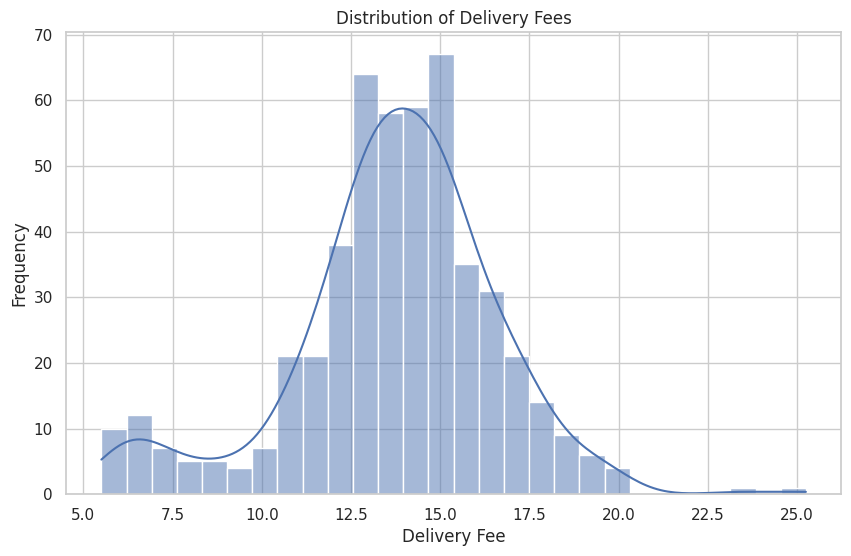

In [549]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting a histogram of delivery fees to see the distribution
plt.figure(figsize=(10, 6))
sns.histplot(outlierdata_60['delivery_fee'], kde=True)
plt.title('Distribution of Delivery Fees')
plt.xlabel('Delivery Fee')
plt.ylabel('Frequency')
plt.show()

## Explanation of histogram-
The distribution of delivery fees appears to be roughly symmetric with a peak around the median value, suggesting a normal distribution for the majority of the data.A peak around 15, indicating this is the most common delivery fee value.It mostly fall between 10 and 20, with a higher concentration between 12.5 and 17.5.
There are some values extending beyond 20, up to around 25, which are less frequent.
There are a few noticeable outliers on both the lower end (around 5 to 10) and the higher end (above 20).
The lower end outliers are more frequent compared to the higher end.



# let see the boxplot for delivery_fee column

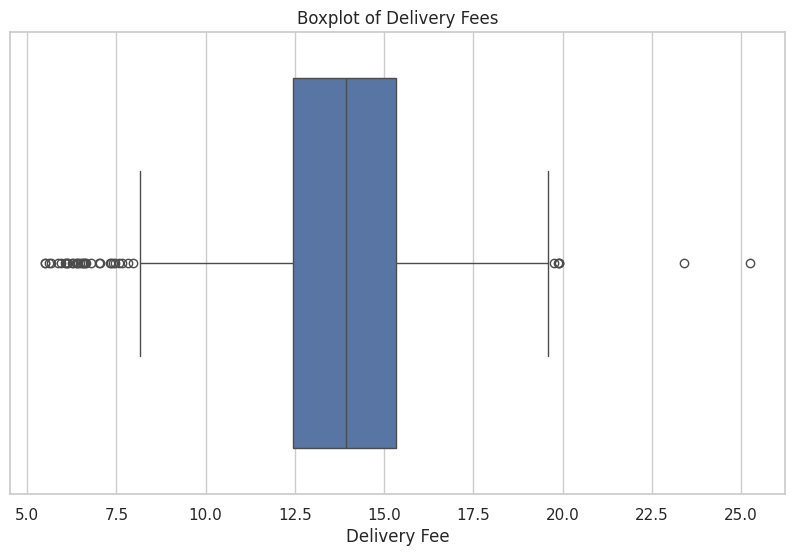

In [550]:
# Plotting a boxplot to visualize potential outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=outlierdata_60['delivery_fee'])
plt.title('Boxplot of Delivery Fees')
plt.xlabel('Delivery Fee')
plt.show()



## Explanation  of boxplot-
The median (the line inside the box) is around 15, which is the central value of the delivery fee data.
The lower quartile (Q1) is around 12.5, and the upper quartile (Q3) is around 17.5. This means that 50% of the delivery fees fall between these values.The whiskers extend to the smallest and largest values within 1.5 * IQR from Q1 and Q3, respectively. The left whisker extends to around 10, and the right whisker extends to around 20.
Any data points outside the whiskers are considered outliers.
There are a few outliers on both the lower end (less than 10) and the higher end (greater than 20) of the delivery fee values.



# Range(mininmum and maximum) of delivery_fee column data

In [551]:
# Print the range of the delivery fee data
min_fee = outlierdata_60['delivery_fee'].min()
max_fee = outlierdata_60['delivery_fee'].max()
print(f"\nRange of delivery fees: {min_fee} to {max_fee}")


Range of delivery fees: 5.5038801 to 25.24600305


# using quantile function to find upper and lower boound


In [552]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = outlierdata_60['delivery_fee'].quantile(0.25)
Q3 = outlierdata_60['delivery_fee'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Calculated lower bound for delivery fees: {lower_bound}")
print(f"Calculated upper bound for delivery fees: {upper_bound}")


Calculated lower bound for delivery fees: 8.144572387499995
Calculated upper bound for delivery fees: 19.652314487500004


# Visualizing original delivery_fee column along with quantile lower and upper bounds

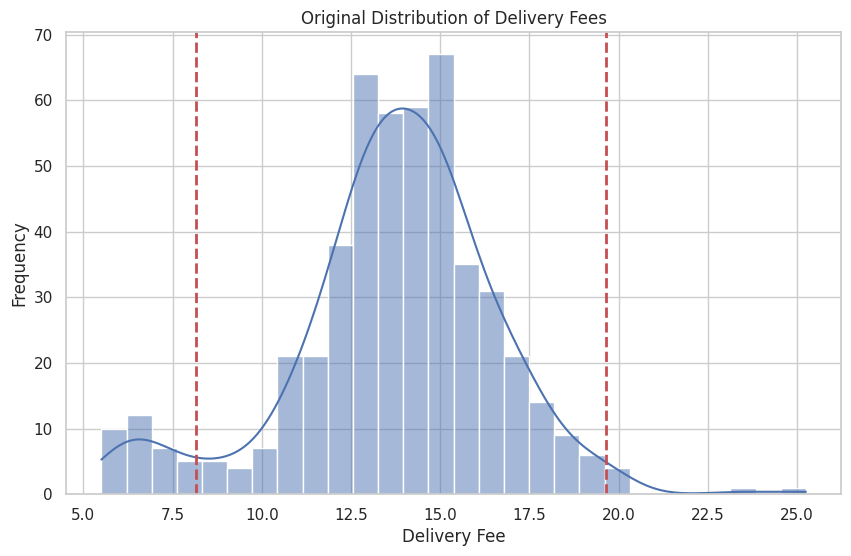

In [553]:
# Visualize the data
plt.figure(figsize=(10, 6))
sns.histplot(outlierdata_60['delivery_fee'], kde=True)
plt.title('Original Distribution of Delivery Fees')
plt.xlabel('Delivery Fee')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.show()

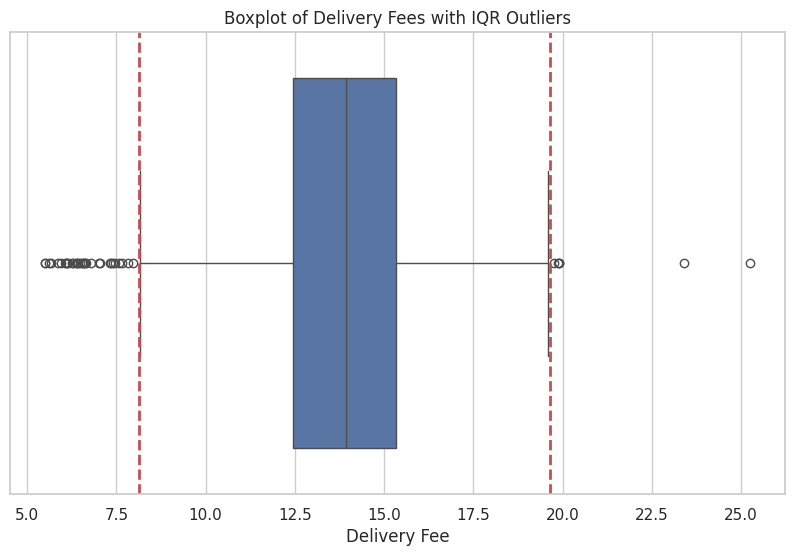

In [554]:
# Visualize IQR outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=outlierdata_60['delivery_fee'])
plt.title('Boxplot of Delivery Fees with IQR Outliers')
plt.xlabel('Delivery Fee')
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.show()


# Calculating number of outliers detected by using quantile

In [555]:
# Identify outliers
outliers = outlierdata_60[(outlierdata_60['delivery_fee'] < lower_bound) | (outlierdata_60['delivery_fee'] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 38


In [556]:
print("Some outliers in the data:")
print(outliers.head())

Some outliers in the data:
     order_id        date      time order_type branch_code  \
4   ORDC01526  2018-01-14  08:20:16  Breakfast          NS   
6   ORDJ07264  2018-01-17  08:30:25  Breakfast          TP   
34  ORDB01195  2018-03-27  10:42:15  Breakfast          TP   
41  ORDC01531  2018-01-21  08:40:33  Breakfast          NS   
42  ORDX01974  2018-01-17  08:30:25  Breakfast          BK   

                                       order_items  order_price  customer_lat  \
4   [('Pancake', 7), ('Cereal', 3), ('Coffee', 9)]       300.25    -37.807139   
6     [('Cereal', 1), ('Pancake', 7), ('Eggs', 7)]       344.75    -37.808085   
34                 [('Cereal', 10), ('Coffee', 7)]       262.50    -37.809194   
41   [('Eggs', 10), ('Coffee', 7), ('Pancake', 8)]       466.50    -37.803234   
42   [('Pancake', 5), ('Eggs', 4), ('Cereal', 10)]       419.25    -37.806327   

    customer_lon  customerHasloyalty?  distance_to_customer_KM  delivery_fee  
4     144.991677                  

## we found 38 outliers using quantile function for all branches

In [557]:
def find_outliers_iqr(data):
    Q1 = data['delivery_fee'].quantile(0.25)
    Q3 = data['delivery_fee'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data['delivery_fee'] < lower_bound) | (data['delivery_fee'] > upper_bound)]
    return outliers

# Group data by 'branch_code' and apply the outlier detection function
grouped = outlierdata_60.groupby('branch_code')
outliers_by_branch = grouped.apply(find_outliers_iqr)

# Flatten the index to make the DataFrame easier to work with
outliers_by_branch.reset_index(drop=True, inplace=True)

# Count the total number of outliers found across all branches
total_outliers = len(outliers_by_branch)
print(f"\nTotal number of outliers across all branches: {total_outliers}")



Total number of outliers across all branches: 29


### We found 29 outliers using quantile function by using  branches separately and then adding them. the score is different because as it is given that Delivery fee is calculated using a different method for each branch. The fee depends linearly (but in different ways for each branch).

# Detecting outliers using z score

In [558]:

import seaborn as sns
from scipy import stats# Calculate Z-scores
outlierdata_60['z_score'] = stats.zscore(outlierdata_60['delivery_fee'])
# Define bounds for outliers using Z-score
outliers_Z = outlierdata_60[(outlierdata_60['z_score'] > 2) | (outlierdata_60['z_score'] < -2)]
print(f"Number of outliers detected: {len(outliers_Z)}")


Number of outliers detected: 39


In [559]:
print(outliers_Z.head())

     order_id        date      time order_type branch_code  \
4   ORDC01526  2018-01-14  08:20:16  Breakfast          NS   
6   ORDJ07264  2018-01-17  08:30:25  Breakfast          TP   
34  ORDB01195  2018-03-27  10:42:15  Breakfast          TP   
41  ORDC01531  2018-01-21  08:40:33  Breakfast          NS   
42  ORDX01974  2018-01-17  08:30:25  Breakfast          BK   

                                       order_items  order_price  customer_lat  \
4   [('Pancake', 7), ('Cereal', 3), ('Coffee', 9)]       300.25    -37.807139   
6     [('Cereal', 1), ('Pancake', 7), ('Eggs', 7)]       344.75    -37.808085   
34                 [('Cereal', 10), ('Coffee', 7)]       262.50    -37.809194   
41   [('Eggs', 10), ('Coffee', 7), ('Pancake', 8)]       466.50    -37.803234   
42   [('Pancake', 5), ('Eggs', 4), ('Cereal', 10)]       419.25    -37.806327   

    customer_lon  customerHasloyalty?  distance_to_customer_KM  delivery_fee  \
4     144.991677                    1                    8.4

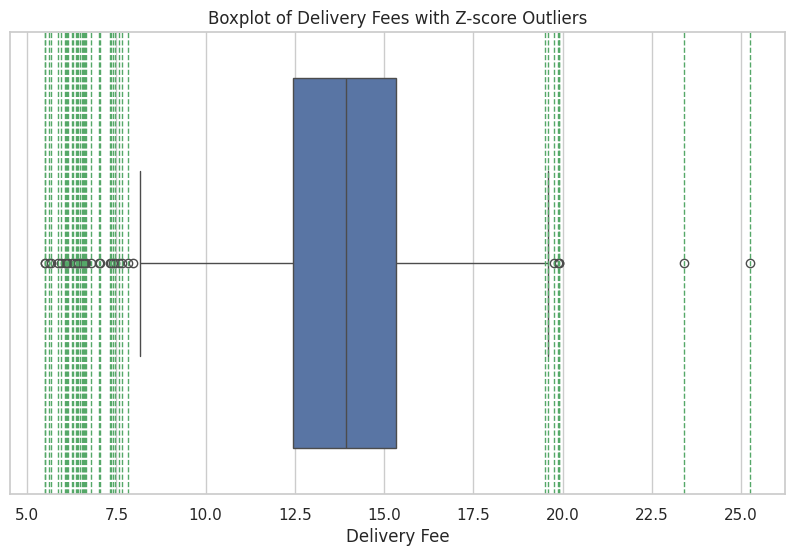

In [560]:
# Visualize Z-score outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=outlierdata_60['delivery_fee'])
plt.title('Boxplot of Delivery Fees with Z-score Outliers')
plt.xlabel('Delivery Fee')
for outlier in outliers_Z['delivery_fee']:
    plt.axvline(outlier, color='g', linestyle='dashed', linewidth=1)
plt.show()

## number of outliers detected by z score 39

# Detecting outliers using Linear regression model we made above in missing data

In [561]:
# Load the trained model
model = joblib.load('trained_delivery_fee_model.pkl')
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_to_customer_KM',
                                                   'customerHasloyalty?',
                                                   'weekend', 'weekday',
                                                   'time_of_day']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['order_type',
                                                   'branch_code'])])),
                ('regressor', LinearRegression())])


In [562]:
# Feature Engineering for outlierdata_60 file
def get_time_of_day(hour):
    if hour < 12:
        return 0  # Morning
    elif 12 <= hour < 18:
        return 1  # Afternoon
    else:
        return 2  # Evening

outlierdata_60['time_of_day'] = pd.to_datetime(outlierdata_60['time']).dt.hour.apply(get_time_of_day)
outlierdata_60['weekday'] = pd.to_datetime(outlierdata_60['date']).dt.weekday
outlierdata_60['weekend'] = outlierdata_60['weekday'].apply(lambda x: 1 if x >= 5 else 0)


<ipython-input-562-52c857107746>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  outlierdata_60['time_of_day'] = pd.to_datetime(outlierdata_60['time']).dt.hour.apply(get_time_of_day)


In [563]:
# Define categorical and numeric features
categorical_features = ['order_type', 'branch_code']
numeric_features = ['distance_to_customer_KM', 'customerHasloyalty?',  'weekend','weekday', 'time_of_day']
X_outlier = outlierdata_60[categorical_features + numeric_features]
# Predict delivery fees
predicted_fees = model.predict(X_outlier)
# Apply the 50% discount for customers with loyalty.
outlierdata_60['predicted_delivery_fee'] = predicted_fees * (1 - 0.5 * outlierdata_60['customerHasloyalty?'])

In [564]:
outlierdata_60['residuals'] = outlierdata_60['delivery_fee'] - outlierdata_60['predicted_delivery_fee']
# Calculate Q1 (25th percentile) and Q3 (75th percentile) of the residuals
Q1 = outlierdata_60['residuals'].quantile(0.25)
Q3 = outlierdata_60['residuals'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the residuals
outlierdata_60['is_residual_outlier'] = (outlierdata_60['residuals'] < lower_bound) | (outlierdata_60['residuals'] > upper_bound)
# Count the number of outliers
number_of_outliers = outlierdata_60['is_residual_outlier'].sum()
print(f"Number of outliers found: {number_of_outliers}")
# Extract the rows marked as outliers
outlier_rows = outlierdata_60[outlierdata_60['is_residual_outlier']]

# Print the number of outliers found
print(f"Number of outliers found: {len(outlier_rows)}")

# Display the outliers
print("Outliers details:")
print(outlier_rows[['order_id', 'delivery_fee', 'predicted_delivery_fee', 'residuals']])


Number of outliers found: 21
Number of outliers found: 21
Outliers details:
      order_id  delivery_fee  predicted_delivery_fee  residuals
30   ORDX04771      9.485944               10.864718  -1.378774
34   ORDB01195      5.672146               11.459685  -5.787540
41   ORDC01531      7.008041               13.465861  -6.457820
81   ORDX04359     19.911829               13.387963   6.523866
82   ORDB09060     19.585510               12.475552   7.109958
84   ORDJ07139     19.357899               12.705426   6.652473
88   ORDX05792     16.521529               11.124116   5.397413
133  ORDJ04426     19.283019               13.180868   6.102152
151  ORDB00442     23.409082               15.271029   8.138053
232  ORDX05601     25.246003               16.204782   9.041221
261  ORDK08048      8.164498                6.048603   2.115895
264  ORDX04490      6.470736               13.031425  -6.560689
266  ORDA08490      6.242855               12.418240  -6.175385
338  ORDK04380      7.320740

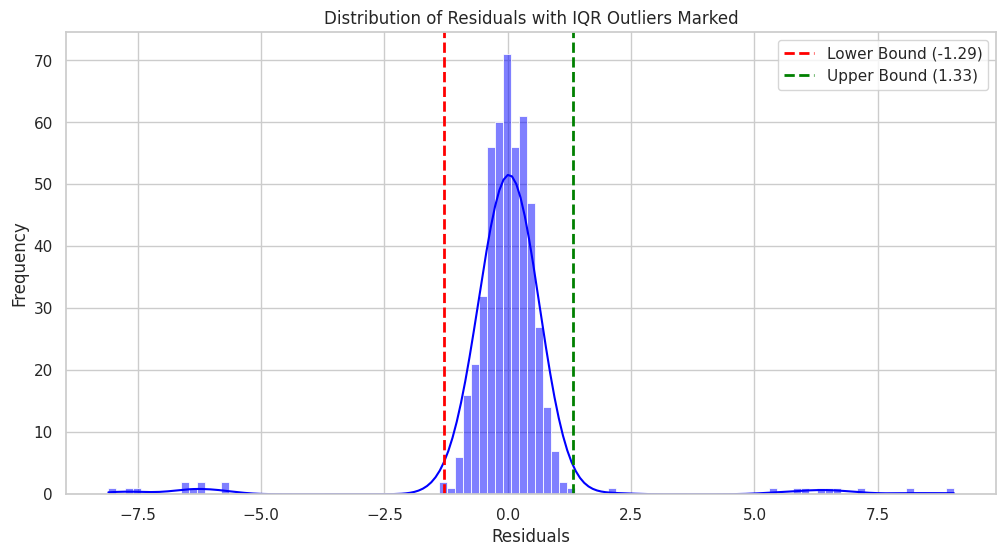

In [565]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the plot dimensions and style
plt.figure(figsize=(12, 6))

# Plotting the histogram of residuals
sns.histplot(outlierdata_60['residuals'], kde=True, color='blue')

# Adding lines for lower and upper bounds
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f'Upper Bound ({upper_bound:.2f})')

# Adding plot titles and labels
plt.title('Distribution of Residuals with IQR Outliers Marked')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()


The histogram indicates a mostly symmetric distribution of residuals centered around zero, suggesting that  predictive model is performing adequately in centering predictions around actual values.The dashed lines indicate the bounds calculated by the IQR method. Values falling outside these bounds are considered outliers.

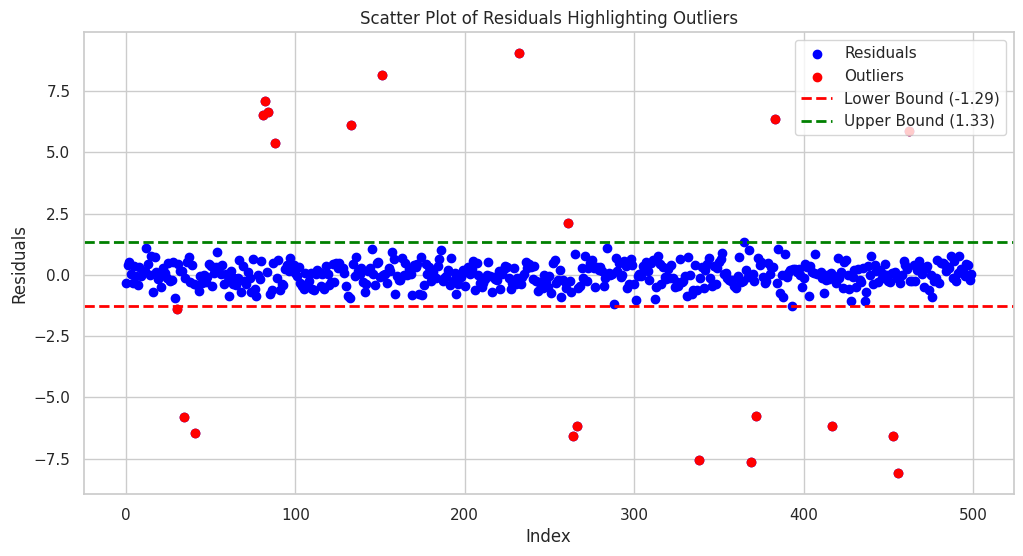

In [566]:
plt.figure(figsize=(12, 6))

# Plotting all residuals
plt.scatter(outlierdata_60.index, outlierdata_60['residuals'], color='blue', label='Residuals')

# Highlighting the outliers
plt.scatter(outlierdata_60[outlierdata_60['is_residual_outlier']].index,
            outlierdata_60[outlierdata_60['is_residual_outlier']]['residuals'],
            color='red', label='Outliers')

# Adding lines for lower and upper bounds
plt.axhline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lower_bound:.2f})')
plt.axhline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f'Upper Bound ({upper_bound:.2f})')

# Adding plot titles and labels
plt.title('Scatter Plot of Residuals Highlighting Outliers')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()

# Show the plot
plt.show()


In [567]:
# Filter out the outliers
clean_data = outlierdata_60[~outlierdata_60['is_residual_outlier']]
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 479 non-null    object 
 1   date                     479 non-null    object 
 2   time                     479 non-null    object 
 3   order_type               479 non-null    object 
 4   branch_code              479 non-null    object 
 5   order_items              479 non-null    object 
 6   order_price              479 non-null    float64
 7   customer_lat             479 non-null    float64
 8   customer_lon             479 non-null    float64
 9   customerHasloyalty?      479 non-null    int64  
 10  distance_to_customer_KM  479 non-null    float64
 11  delivery_fee             479 non-null    float64
 12  z_score                  479 non-null    float64
 13  time_of_day              479 non-null    int64  
 14  weekday                  479 no

In [568]:
clean_data.drop(['z_score','time_of_day','weekday','weekend','predicted_delivery_fee','residuals','is_residual_outlier'], axis=1, inplace=True)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 479 non-null    object 
 1   date                     479 non-null    object 
 2   time                     479 non-null    object 
 3   order_type               479 non-null    object 
 4   branch_code              479 non-null    object 
 5   order_items              479 non-null    object 
 6   order_price              479 non-null    float64
 7   customer_lat             479 non-null    float64
 8   customer_lon             479 non-null    float64
 9   customerHasloyalty?      479 non-null    int64  
 10  distance_to_customer_KM  479 non-null    float64
 11  delivery_fee             479 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 48.6+ KB


<ipython-input-568-447e3584a47d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.drop(['z_score','time_of_day','weekday','weekend','predicted_delivery_fee','residuals','is_residual_outlier'], axis=1, inplace=True)


In [569]:
clean_data.to_csv('outlier_data.csv', index=False)

## Final Decision:A combined approach of model and quantile

## The use of both statistical outlier detection and predictive modeling provided a comprehensive view of outliers. While the initial statistical methods (IQR and Z-score) provided a broad detection of potential outliers, the predictive modeling approach offered a contextual validation.
## Conclusion: Given the similar results from IQR and Z-score methods and the additional insights from the model-based residual analysis, it was evident that a combined approach was most effective. The residual analysis not only confirmed the outliers identified statistically but also provided a rationale for their deviation, supporting a more informed decision-making process regarding outlier handling.


# **TASK2**

In [582]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from scipy.stats import boxcox
from scipy.stats import skew






In [583]:
suburb = pd.read_excel('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/suburb_info.xlsx',usecols = [1,2,4,5,6,7])
suburb.head(10)

,number_of_houses,number_of_units,aus_born_perc,median_income,median_house_price,population
0,2304,4706,68%,"$1,797","$1,299,400",4025
1,1410,453,81%,"$1,571","$1,926,600",22442
2,1897,138,46%,$907,"$594,200",54005
3,1389,1392,52%,$929,"$739,100",30677
4,1729,1099,73%,"$1,538","$1,729,600",9227
5,4843,2394,70%,"$1,160","$1,139,500",11742
6,5002,1622,52%,$910,"$935,500",12830
7,1263,335,46%,$895,"$663,400",10176
8,2838,3841,73%,"$1,713","$1,925,900",8428
9,2378,1176,73%,"$1,469","$1,436,500",12420


In [584]:
suburb.shape

(202, 6)

Prior to executing any scaling or transformation, it's critical to determine whether the dataset contains any missing values that require attention. In order to convert aus_born_perc and median_income into numeric data types for analysis, non-numeric characters (%, $) in these columns must be cleaned. Additionally, it looks that median_house_price has a dollar sign; the format consistency of this should be verified.

In [585]:
# Removing percentage sign and converting to float
suburb['aus_born_perc'] = suburb['aus_born_perc'].str.replace('%', '').astype(float)

# Removing dollar sign and commas if present, and then converting to float
suburb['median_income'] = suburb['median_income'].str.replace('$', '').replace(',', '', regex=True).astype(float)
suburb['median_house_price'] = suburb['median_house_price'].str.replace('$', '').replace(',', '', regex=True).astype(float)

# Displaying the cleaned data
suburb.head()

,number_of_houses,number_of_units,aus_born_perc,median_income,median_house_price,population
0,2304,4706,68.0,1797.0,1299400.0,4025
1,1410,453,81.0,1571.0,1926600.0,22442
2,1897,138,46.0,907.0,594200.0,54005
3,1389,1392,52.0,929.0,739100.0,30677
4,1729,1099,73.0,1538.0,1729600.0,9227


In [586]:
# Check for missing values
missing_values = suburb.isnull().sum()
print(missing_values)

number_of_houses      0
number_of_units       0
aus_born_perc         0
median_income         0
median_house_price    0
population            0
dtype: int64


In [587]:
# Generate descriptive statistics
descriptive_stats = suburb.describe()
print(descriptive_stats)

       number_of_houses  number_of_units  aus_born_perc  median_income  \
count        202.000000       202.000000     202.000000     202.000000   
mean        4155.767327      2480.410891      68.366337    1387.935644   
std         3400.864988      3132.684712      10.761293     317.841321   
min          283.000000        60.000000      36.000000     633.000000   
25%         1973.500000       620.500000      62.000000    1182.250000   
50%         3256.500000      1603.000000      70.000000    1393.000000   
75%         5518.500000      3089.000000      77.000000    1560.000000   
max        23338.000000     24380.000000      88.000000    2352.000000   

       median_house_price    population  
count        2.020000e+02    202.000000  
mean         1.218817e+06  18659.311881  
std          4.716807e+05   9604.187282  
min          5.072000e+05    170.000000  
25%          8.706750e+05  12063.000000  
50%          1.134500e+06  17583.000000  
75%          1.467550e+06  24045.000000

Understanding the distribution and relationships in the data is crucial before choosing on transformations or scaling. The next step will assist us in identifying the potential types of transformations that may be required. We will examine the distributions and linearity of the target variable (median house price) and all of the features (number of houses, number of units, population, aus born percentage, median income). We will also calculate the skewness and correlation coefficients.

### **Let's use histograms, scatterplots, correlation coefficients and skewness to analyse each feature**

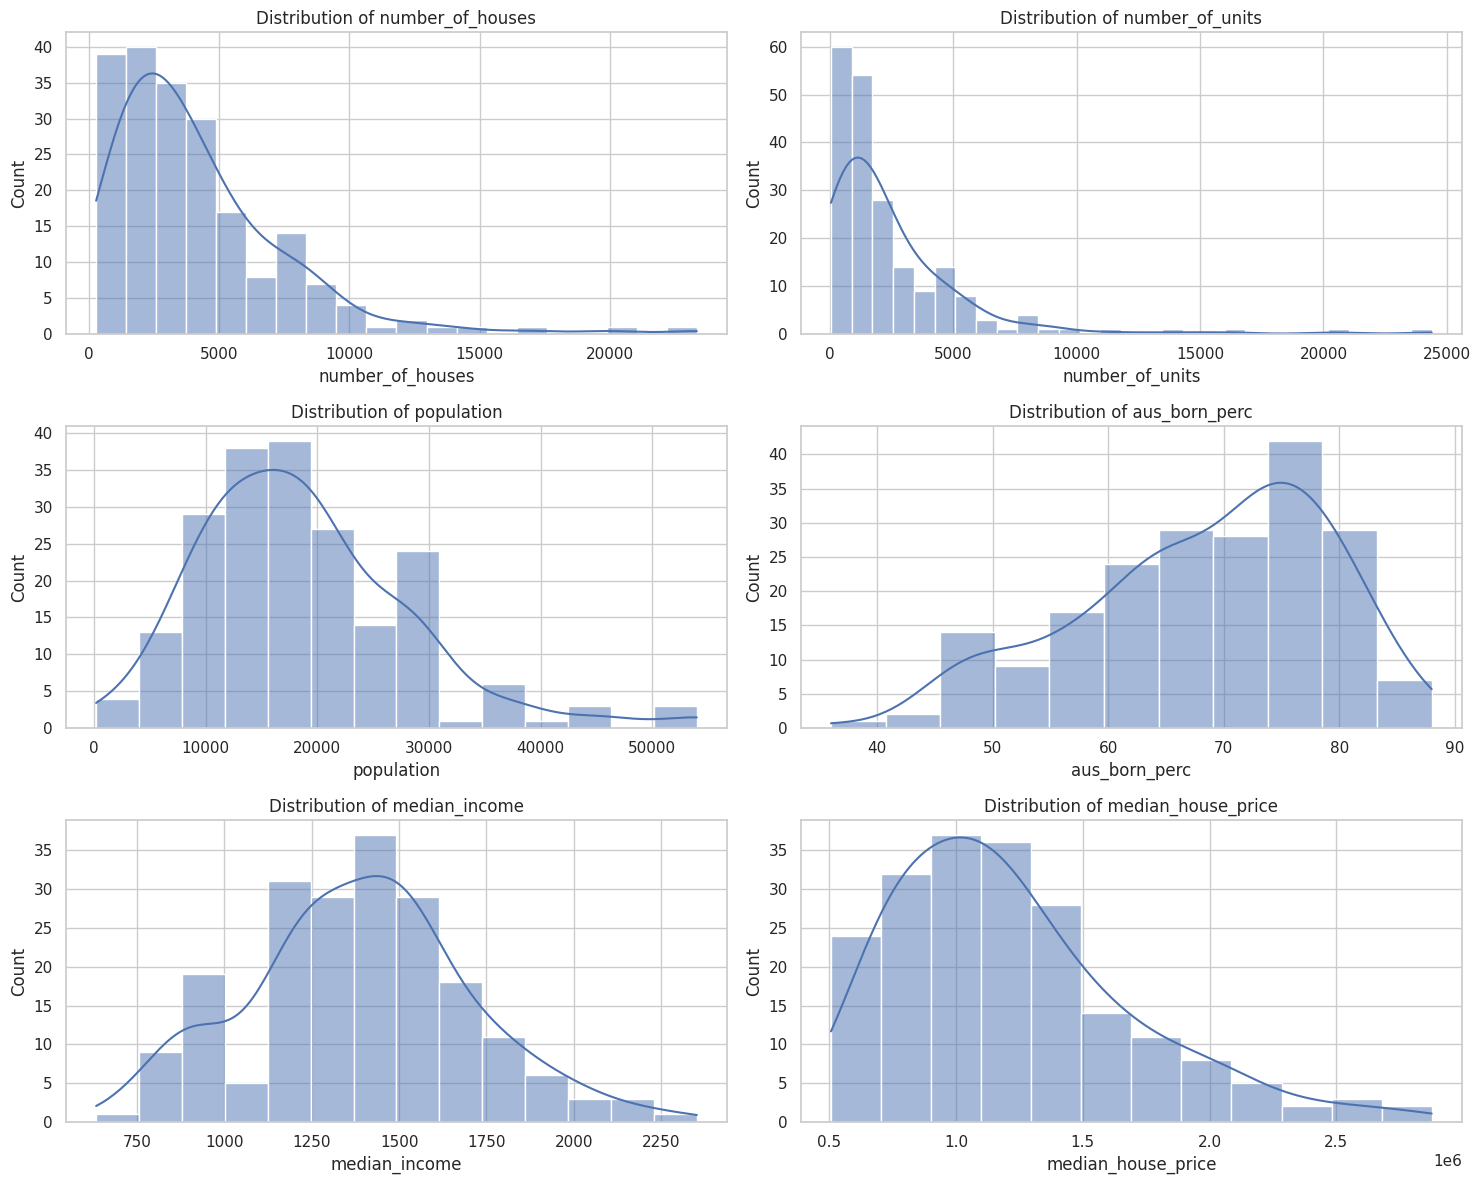

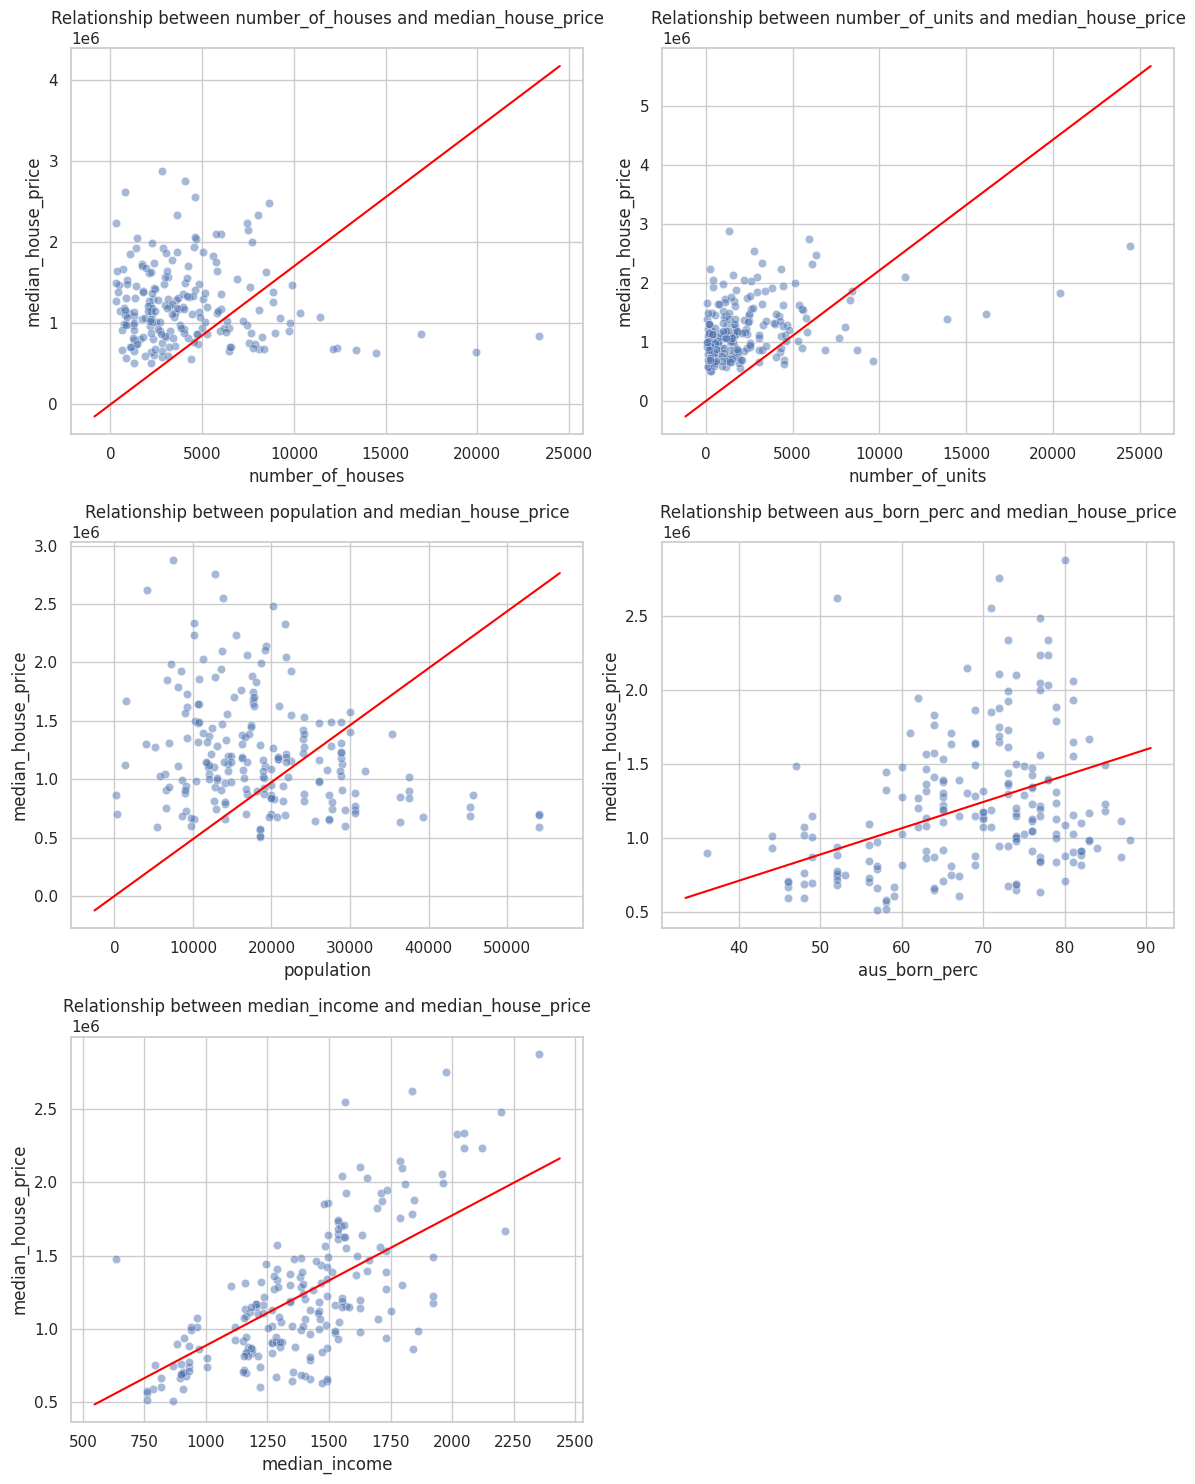

In [588]:


sns.set(style="whitegrid")

# Columns to plot
columns = ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income', 'median_house_price']

# Histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
for i, col in enumerate(columns):
    sns.histplot(suburb[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.savefig('distributions.png')
plt.show()

# Scatter plots with regression lines passing through the origin
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
for i, col in enumerate(columns[:-1]):  # Exclude 'median_house_price' itself
    sns.scatterplot(x=suburb[col], y=suburb['median_house_price'], ax=axes[i//2, i%2], alpha=0.5)
    axes[i//2, i%2].set_title(f'Relationship between {col} and median_house_price')

    # Fit a regression line passing through the origin
    slope = np.sum(suburb[col] * suburb['median_house_price']) / np.sum(suburb[col] ** 2)
    x_vals = np.array(axes[i//2, i%2].get_xlim())
    y_vals = slope * x_vals
    axes[i//2, i%2].plot(x_vals, y_vals, color='red')

# Hide the last empty subplot
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.savefig('scatterplots.png')
plt.show()


# **Observation**

**Distributions:**

The number of houses and units both exhibit right-skewed distributions, with most areas having relatively small quantities and a few areas possessing significantly higher numbers. The population distribution appears more normal, with a bell-shaped curve indicating most areas fall within a specific range and fewer areas having extreme populations. The percentage of Australian-born residents shows a slight left-skew. Median income and median house price also display right-skewed distributions.

Due to the variables' different scales, the comparison and analysis may become more difficult.

**Scatter Plots:**

The scatter plots show the correlations between a number of other variables and median home prices. The data suggests a positive correlation between median income and median house prices, suggesting that higher median income areas typically have higher median house prices. Similarly, although the relationship is not as strong, there is a positive correlation between the percentage of residents who were born in Australia and median house prices. On the other hand, the population, number of units, and number of houses all exhibit less strong correlations with median house prices, with data points dispersed more widely.

In [589]:

skewness = suburb.apply(lambda x: skew(x.dropna()))
print(skewness)

number_of_houses      2.140141
number_of_units       3.603153
aus_born_perc        -0.563670
median_income         0.171234
median_house_price    1.025572
population            1.077785
dtype: float64


**Skewness**

Number of Houses (2.140141):The distribution appears to be right-skewed based on this positive skewness.
Number of Units (3.603153): A more prominently right-skewed distribution compared to the number of houses is indicated by this larger positive skewness.
Positive Skewness: Right-skewed distributions are indicated by positive skewness in variables such as population, median house price, number of houses, and number of units. This indicates that, in relation to the remainder of the data, there are a few exceptionally large values for these variables.

Negative Skewness: The australian-born percentage exhibits negative skewness, which denotes a left-skewed distribution where the tail is made up of a few lower values and the majority of higher values.

Near Symmetrical: The skewness value of the median income is almost 0, suggesting a relatively symmetric distribution.

In [590]:
# Calculating Pearson correlation coefficients
correlations = suburb[columns].corrwith(suburb['median_house_price'])

# Display the correlation coefficients
print("Correlation coefficients before any transformation")
print(correlations)

Correlation coefficients before any transformation
number_of_houses     -0.104490
number_of_units       0.343858
population           -0.287242
aus_born_perc         0.303860
median_income         0.719384
median_house_price    1.000000
dtype: float64


**Correlation Coefficients**

Median income has the strongest positive correlation with median house prices (0.719). The percentage of Australian-born residents has a moderate positive correlation with a correlation coefficient of 0.303. The number of units has a weak positive correlation (0.344), while houses and population have weak negative correlations (-0.104 and -0.287). The presence of negative correlations suggests that more houses or populations do not necessarily mean higher median house prices.

### **Now, let us apply all the scaling and transformation methods and visualize the distributions. We will also calculate the new values of skewness and correlation coefficients after each transformation/scaling method.**

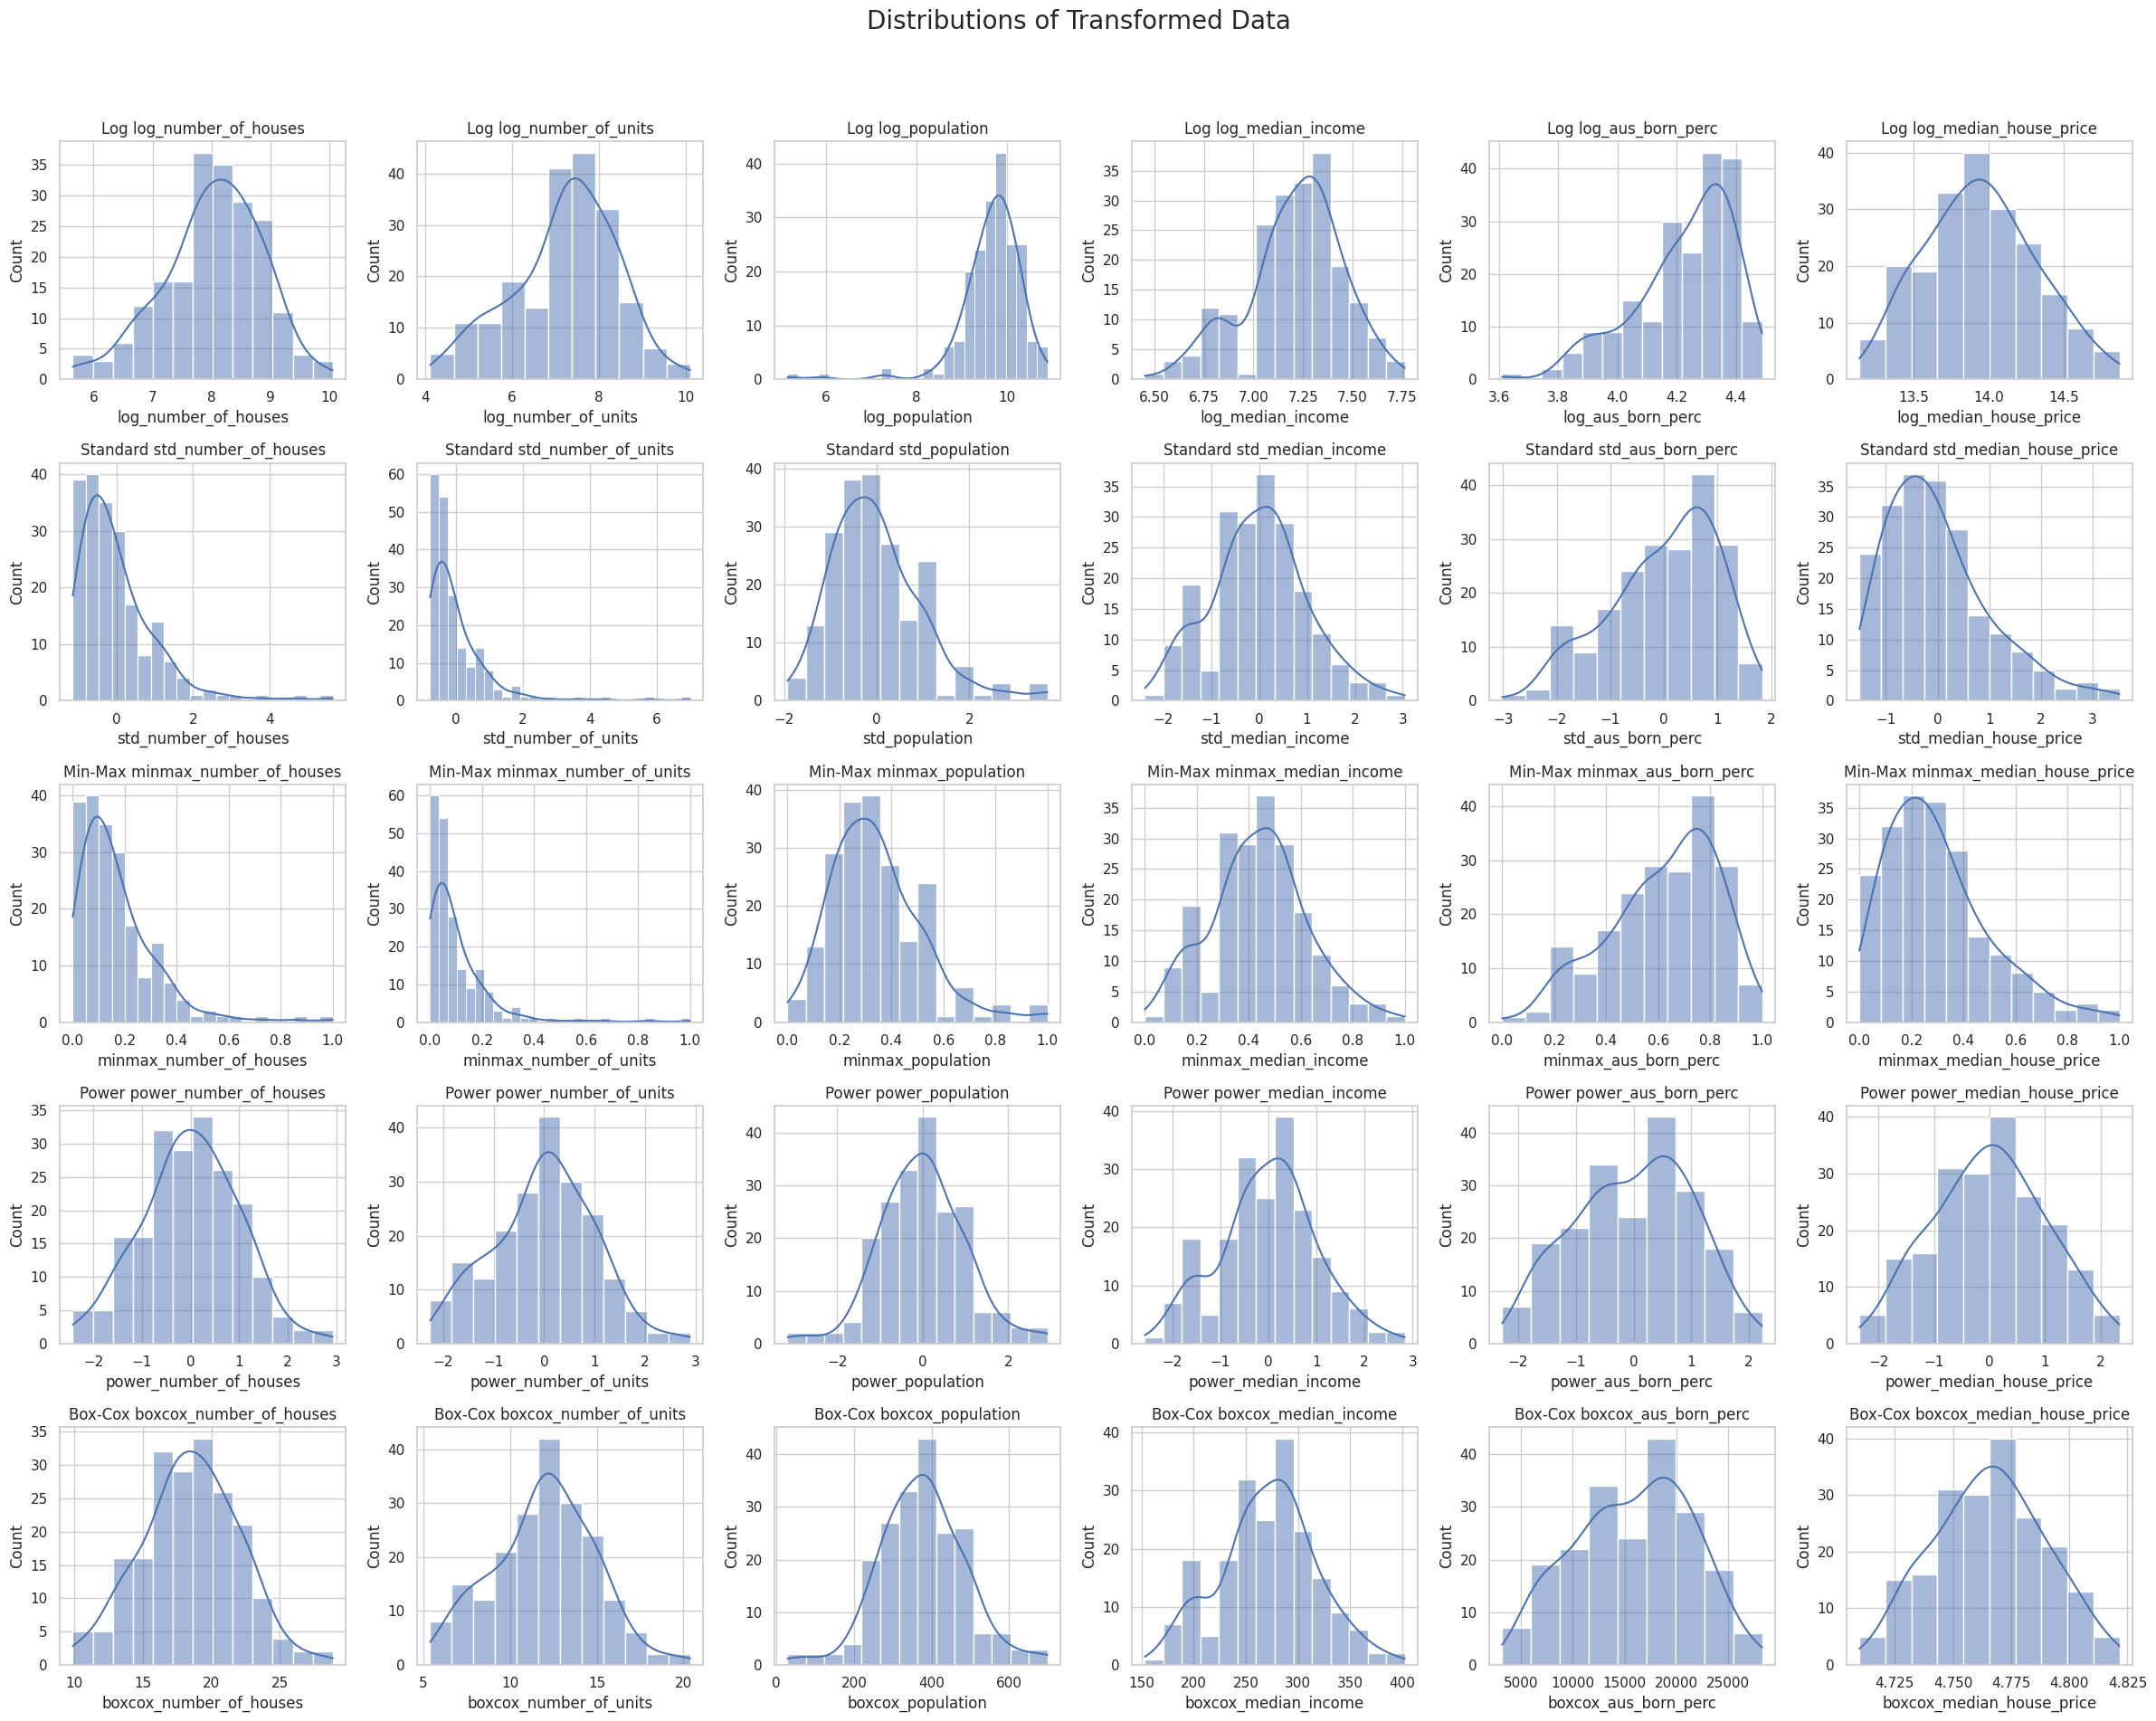

New Skewness after Log Transformation:
log_number_of_houses     -0.437857
log_number_of_units      -0.392352
log_population           -2.621574
log_median_income        -0.497384
log_aus_born_perc        -0.910499
log_median_house_price    0.171658
dtype: float64

New Skewness after Standard Transformation:
std_number_of_houses      2.140141
std_number_of_units       3.603153
std_population            1.077785
std_median_income         0.171234
std_aus_born_perc        -0.563670
std_median_house_price    1.025572
dtype: float64

New Skewness after Min-Max Transformation:
minmax_number_of_houses      2.140141
minmax_number_of_units       3.603153
minmax_population            1.077785
minmax_median_income         0.171234
minmax_aus_born_perc        -0.563670
minmax_median_house_price    1.025572
dtype: float64

New Skewness after Power Transformation:
power_number_of_houses     -0.006369
power_number_of_units      -0.013961
power_population            0.099697
power_median_income       

In [591]:

# Applying transformations
suburb['log_number_of_houses'] = np.log1p(suburb['number_of_houses'])
suburb['log_number_of_units'] = np.log1p(suburb['number_of_units'])
suburb['log_population'] = np.log1p(suburb['population'])
suburb['log_median_income'] = np.log1p(suburb['median_income'])
suburb['log_aus_born_perc'] = np.log1p(suburb['aus_born_perc'])
suburb['log_median_house_price'] = np.log1p(suburb['median_house_price'])

scaler = StandardScaler()
suburb[['std_number_of_houses', 'std_number_of_units', 'std_population', 'std_median_income', 'std_aus_born_perc', 'std_median_house_price']] = scaler.fit_transform(suburb[['number_of_houses', 'number_of_units', 'population', 'median_income', 'aus_born_perc', 'median_house_price']])

scaler = MinMaxScaler()
suburb[['minmax_number_of_houses', 'minmax_number_of_units', 'minmax_population', 'minmax_median_income', 'minmax_aus_born_perc', 'minmax_median_house_price']] = scaler.fit_transform(suburb[['number_of_houses', 'number_of_units', 'population', 'median_income', 'aus_born_perc', 'median_house_price']])

pt = PowerTransformer(method='yeo-johnson')
suburb[['power_number_of_houses', 'power_number_of_units', 'power_population', 'power_median_income', 'power_aus_born_perc', 'power_median_house_price']] = pt.fit_transform(suburb[['number_of_houses', 'number_of_units', 'population', 'median_income', 'aus_born_perc', 'median_house_price']])

suburb['boxcox_number_of_houses'], _ = boxcox(suburb['number_of_houses'] + 1)  # Adding 1 to avoid zero values
suburb['boxcox_number_of_units'], _ = boxcox(suburb['number_of_units'] + 1)
suburb['boxcox_population'], _ = boxcox(suburb['population'] + 1)
suburb['boxcox_median_income'], _ = boxcox(suburb['median_income'] + 1)
suburb['boxcox_aus_born_perc'], _ = boxcox(suburb['aus_born_perc'] + 1)
suburb['boxcox_median_house_price'], _ = boxcox(suburb['median_house_price'] + 1)

# Visualizing all transformed data
transformations = {
    'Log': ['log_number_of_houses', 'log_number_of_units', 'log_population', 'log_median_income', 'log_aus_born_perc', 'log_median_house_price'],
    'Standard': ['std_number_of_houses', 'std_number_of_units', 'std_population', 'std_median_income', 'std_aus_born_perc', 'std_median_house_price'],
    'Min-Max': ['minmax_number_of_houses', 'minmax_number_of_units', 'minmax_population', 'minmax_median_income', 'minmax_aus_born_perc', 'minmax_median_house_price'],
    'Power': ['power_number_of_houses', 'power_number_of_units', 'power_population', 'power_median_income', 'power_aus_born_perc', 'power_median_house_price'],
    'Box-Cox': ['boxcox_number_of_houses', 'boxcox_number_of_units', 'boxcox_population', 'boxcox_median_income', 'boxcox_aus_born_perc', 'boxcox_median_house_price']
}

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(24, 20))
fig.suptitle('Distributions of Transformed Data', fontsize=20)

for i, (trans_name, columns) in enumerate(transformations.items()):
    for j, col in enumerate(columns):
        sns.histplot(suburb[col], kde=True, ax=axes[i, j])
        axes[i, j].set_title(f'{trans_name} {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('all_distributions.png')
plt.show()

# Recalculating skewness for the transformed data
for trans_name, columns in transformations.items():
    new_skewness = suburb[columns].apply(lambda x: skew(x.dropna()))
    print(f"New Skewness after {trans_name} Transformation:")
    print(new_skewness)
    print()

# Calculating Pearson correlation coefficients for each transformation
for trans_name, columns in transformations.items():
    correlations = suburb[columns].corrwith(suburb[columns[-1]])
    print(f"Correlation coefficients after {trans_name} transformation:")
    print(correlations)
    print()


**Observations:**

It looks like the Box-Cox transformation is the best way to deal with skewness and normalise data. It produces distributions that are almost normal and greatly lowers skewness, which is ideal for many statistical tests.
Power transformation is a strong substitute for Box-Cox and likewise exhibits good performance. By using this technique, the variance can be stabilised and the data can become more Gaussian-like. It greatly lessens skewness and improves distribution symmetry.
For strongly skewed data, log transformation is straightforward and efficient, although it is not as good at normalising data as box-cox or power transformations. When it comes to skewed data (such the number of homes, units, and median home price), log transformation dramatically lessens skewness. Distributions continue to deviate from complete normality but become more symmetric.
Although they can be helpful for squaring and scaling data, skewness is not successfully addressed by standardisation or Min-Max scaling. These techniques work better with machine learning algorithms that need data to be in the neighbourhood of zero or within a certain range. The process of standardisation adjusts the data according to standard deviation and centres it around zero. It does not, however, adequately resolve skewness. All variables are compressed to a range of 0 to 1 using min-max scaling. Although it is less severe than on the original scale, skewness is still noticeable.

**Conclusion:**

Based on the observed distributions, Box-Cox transformation is suggested as the best approach given the necessity to normalise distributions and minimise skewness.

### **Let us compare the skewness and correlation coefficients for each method and choose which is best suited.**

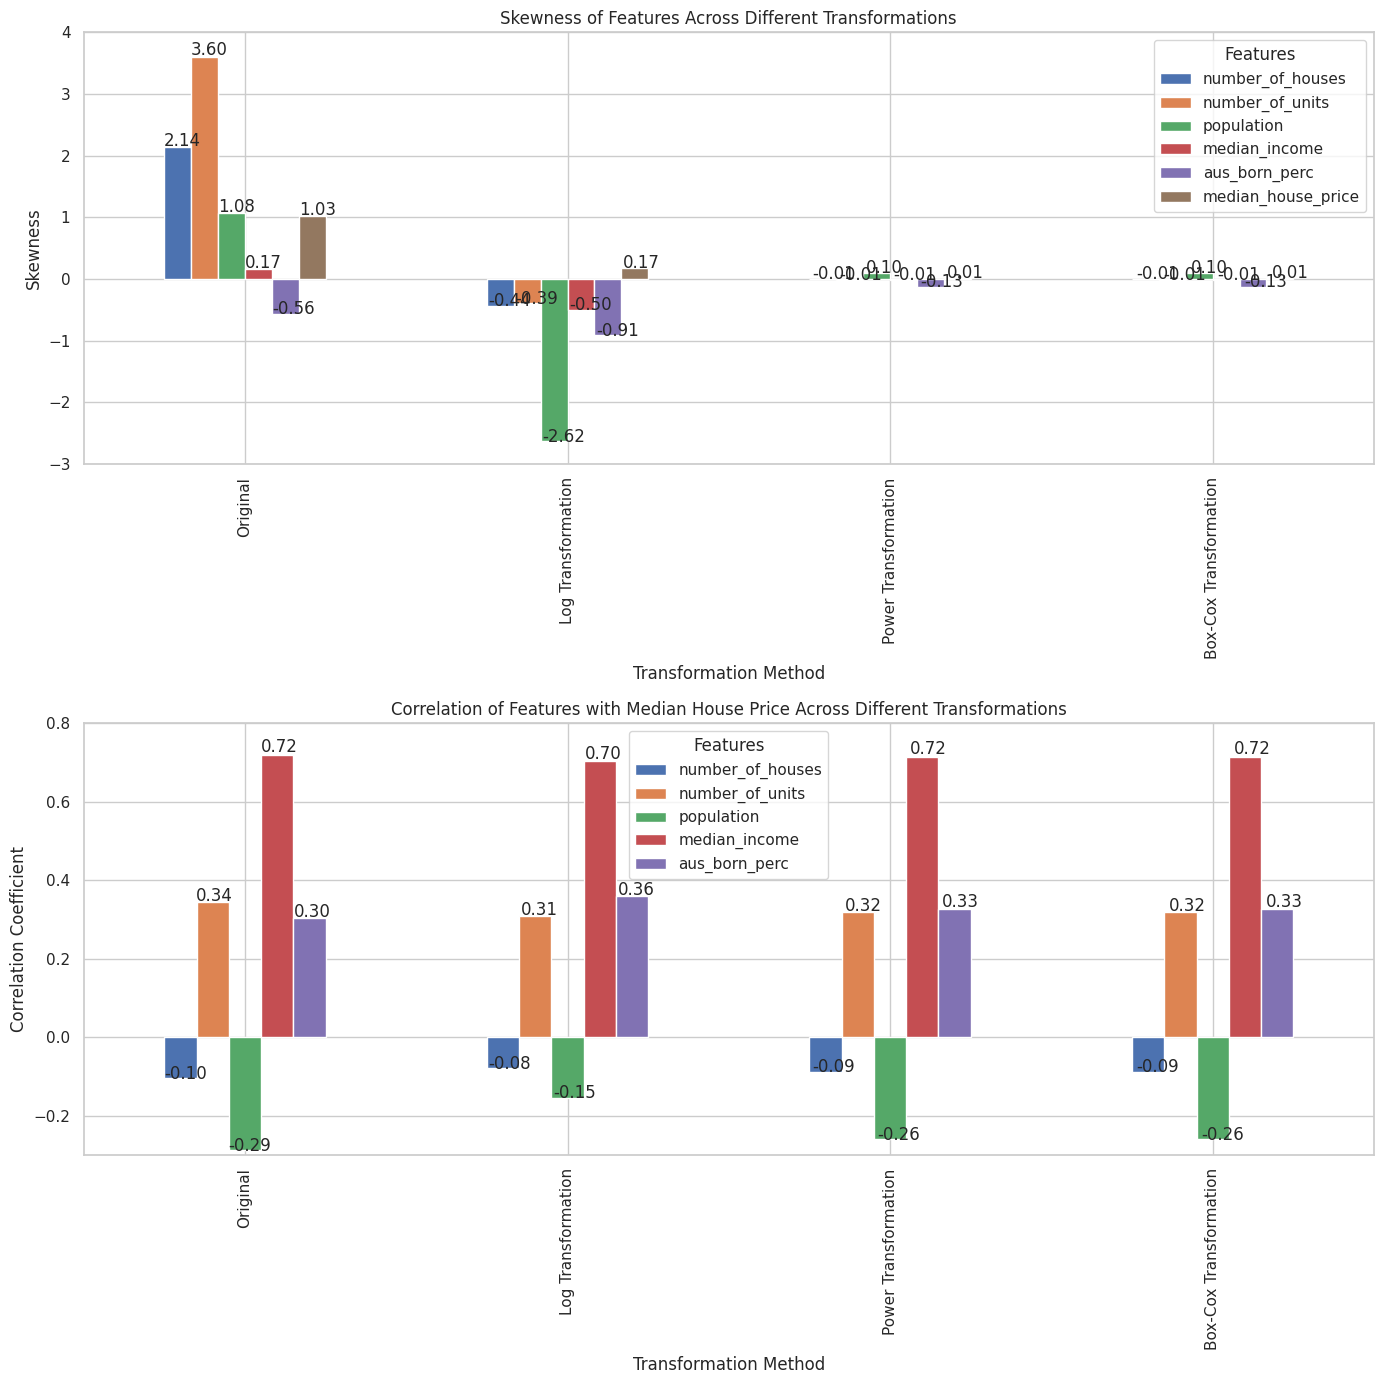

In [592]:
# Data for visualization
methods_filtered = ['Original', 'Log Transformation', 'Power Transformation', 'Box-Cox Transformation']
skewness_data_filtered = {
    'number_of_houses': [2.140141, -0.437857, -0.006369, -0.006369],
    'number_of_units': [3.603153, -0.392352, -0.013961, -0.013961],
    'population': [1.077785, -2.621574, 0.099697, 0.099697],
    'median_income': [0.171234, -0.497384, -0.008334, -0.008334],
    'aus_born_perc': [-0.563670, -0.910499, -0.126746, -0.126746],
    'median_house_price': [1.025572, 0.171658, 0.013401, 0.013401],
}

correlation_data_filtered = {
    'number_of_houses': [-0.104490, -0.078760, -0.086990, -0.086990],
    'number_of_units': [0.343858, 0.309874, 0.319747, 0.319747],
    'population': [-0.287242, -0.153233, -0.259490, -0.259490],
    'median_income': [0.719384, 0.703341, 0.715099, 0.715099],
    'aus_born_perc': [0.303860, 0.359120, 0.327589, 0.327589],
}

skewness_df_filtered = pd.DataFrame(skewness_data_filtered, index=methods_filtered)
correlation_df_filtered = pd.DataFrame(correlation_data_filtered, index=methods_filtered)

fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Skewness plot
ax = skewness_df_filtered.plot(kind='bar', ax=axes[0])
axes[0].set_title('Skewness of Features Across Different Transformations')
axes[0].set_ylabel('Skewness')
axes[0].set_xlabel('Transformation Method')
axes[0].legend(title='Features')
axes[0].set_ylim(-3, 4)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.01))

# Correlation plot
ax = correlation_df_filtered.plot(kind='bar', ax=axes[1])
axes[1].set_title('Correlation of Features with Median House Price Across Different Transformations')
axes[1].set_ylabel('Correlation Coefficient')
axes[1].set_xlabel('Transformation Method')
axes[1].legend(title='Features')
axes[1].set_ylim(-0.3, 0.8)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.01))

plt.tight_layout()
plt.show()



# **Observations:**

Analysis of Skewness and Correlation Coefficients

Note: Standardization, Min-Max Normalization:

Does not alter the skewness values because the data is just rescaled using these approaches.

# **Skewness**

**Before Transformation:**

High skewness values for number_of_houses, number_of_units, and population.
Moderate skewness for median_house_price.
Near-zero skewness for median_income.

**Log Transformation:**

Greatly minimises skewness across all features.
A more symmetric distribution is indicated by the skewness values of all features, which are either close to zero or slightly negative.

**Power Transformation:**

Reduces skewness for all features.
Skewness values are very close to zero, indicating symmetric distributions.

**Box-Cox Transformation:**

Similar to power transformation, reduces skewness for all features.
Skewness values are close to zero, indicating symmetric distributions.

# **Correlation Coefficients**

**Before Transformation:**

median_income has the highest positive correlation (0.72) with median_house_price.
number_of_units (0.343) and aus_born_perc (0.303) also show positive correlations.
number_of_houses and population show negative correlations.

**Log Transformation:**

Slightly reduces the correlation values but maintains the general trend.
log_median_income has a high positive correlation (0.703).
log_aus_born_perc shows an improved positive correlation (0.359).

**Power Transformation:**

Slightly reduces the correlation values but maintains the general trend.
power_median_income remains highly correlated (0.715).
power_aus_born_perc shows an improved positive correlation (0.328).

**Box-Cox Transformation:**

Similar to power transformation, slightly reduces the correlation values.
boxcox_median_income remains highly correlated (0.715).
boxcox_aus_born_perc shows an improved positive correlation (0.328).

# **Conclusion:**

**Best Method for Scaling and Linear Relationship:**

Box-Cox Transformation and Power Transformation are the best methods.
Reduces skewness to near-zero for all features.
Maintains a high correlation between median_income and median_house_price.
Improves correlation for aus_born_perc and other features.
By normalising the distributions (reducing skewness) and preserving or marginally enhancing the linear relationship with the goal variable, as shown by the correlation coefficients, the Box-Cox and Power transformations offer the best solution.

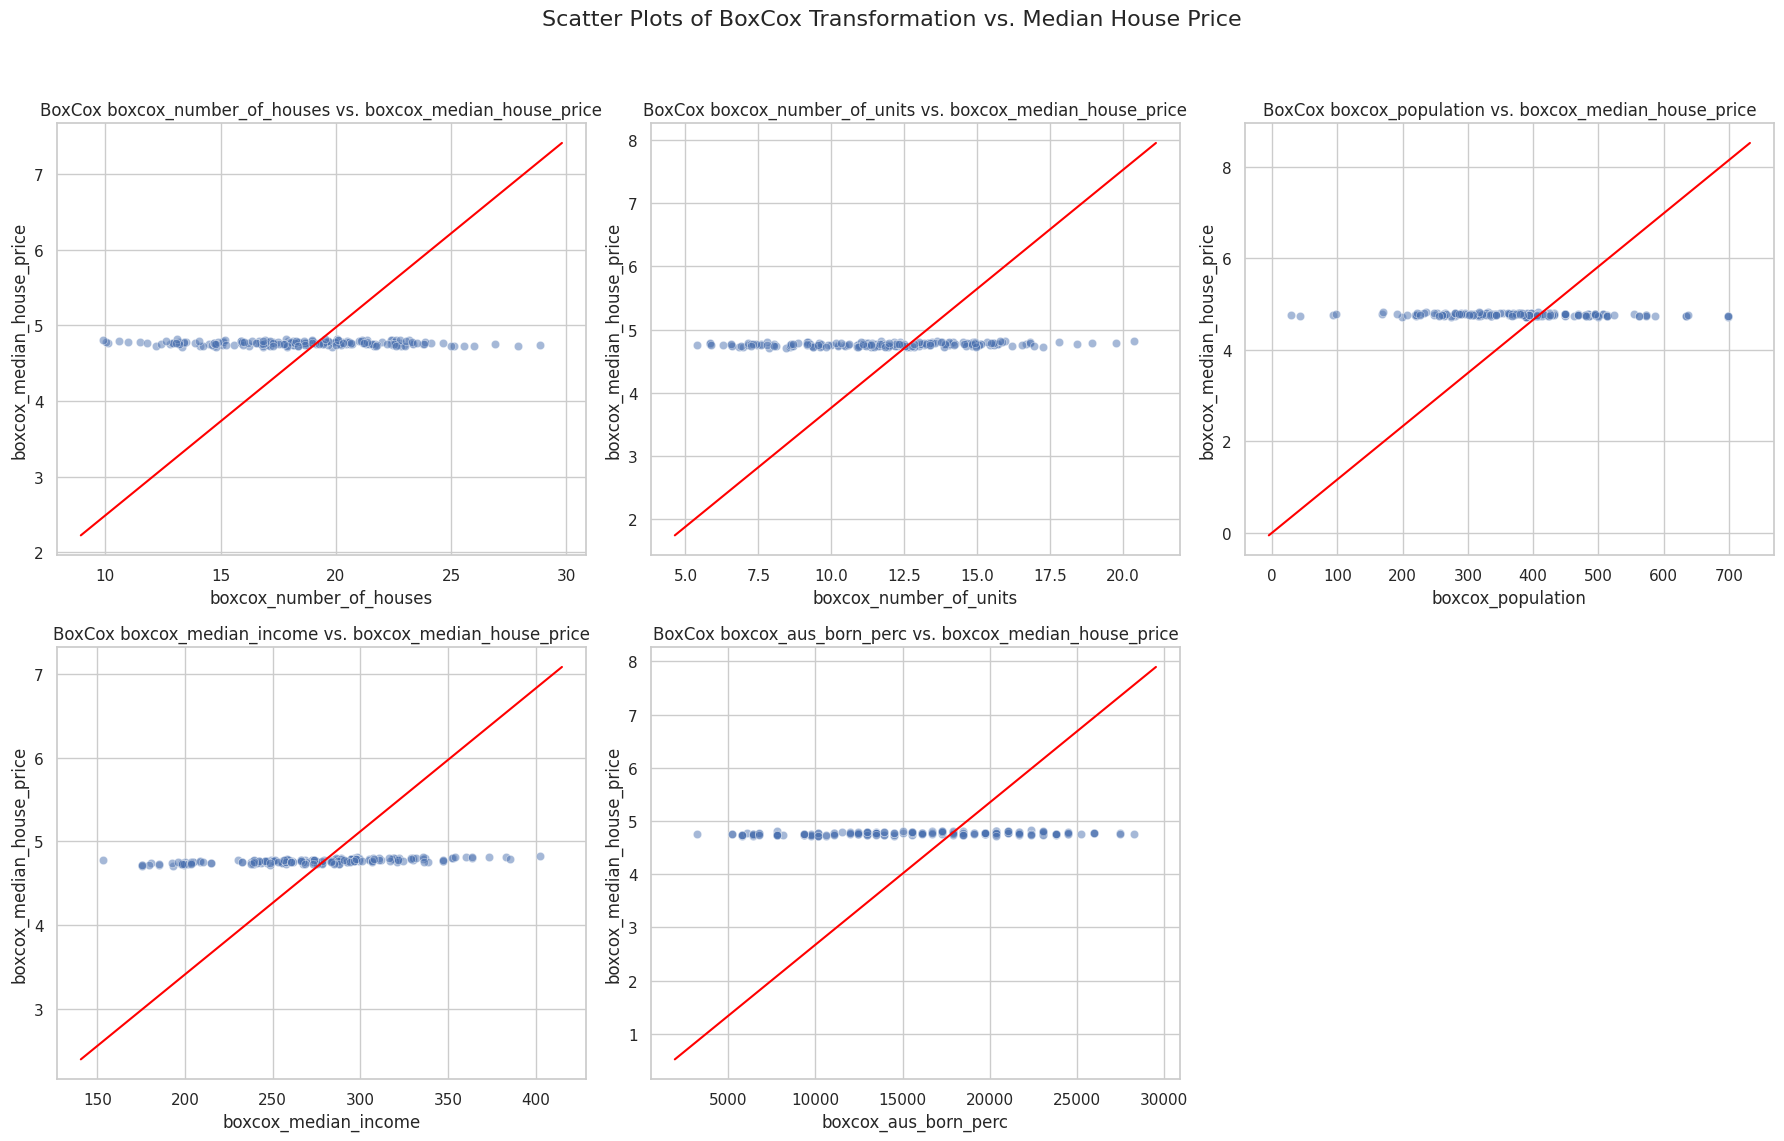

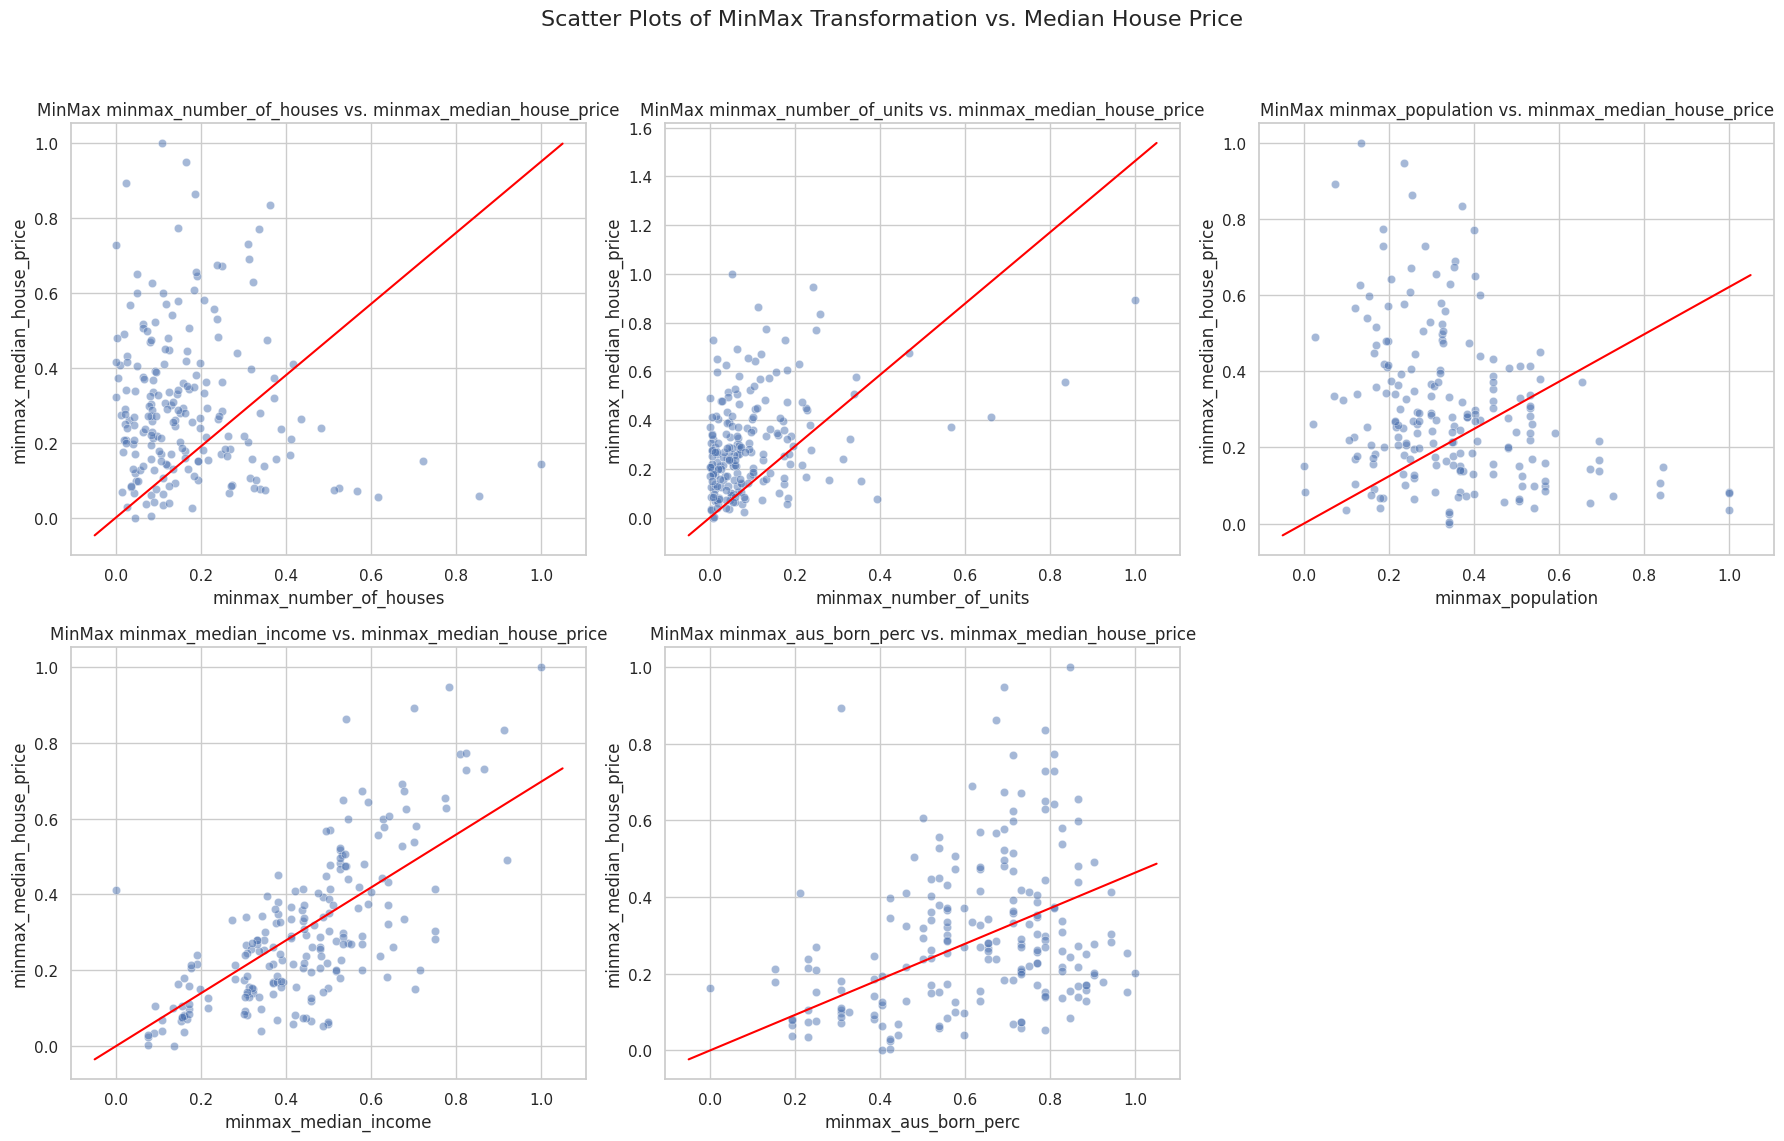

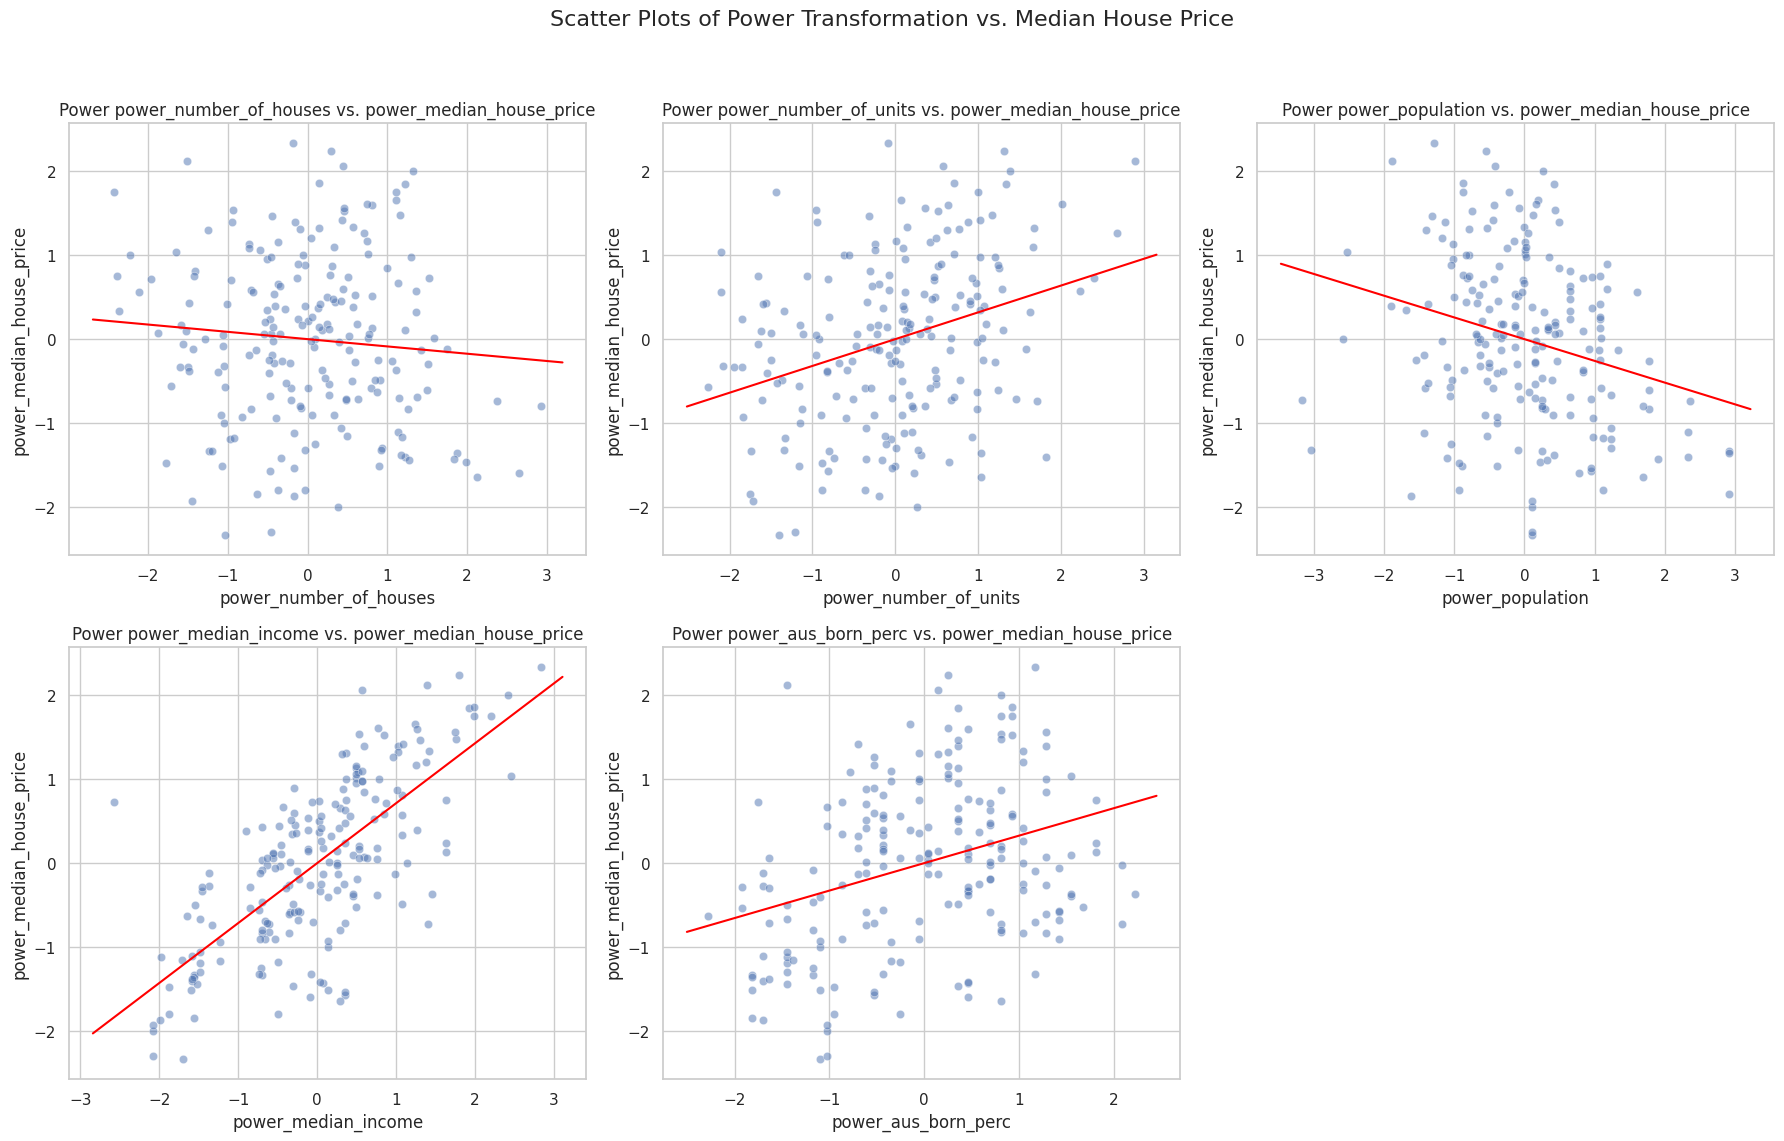

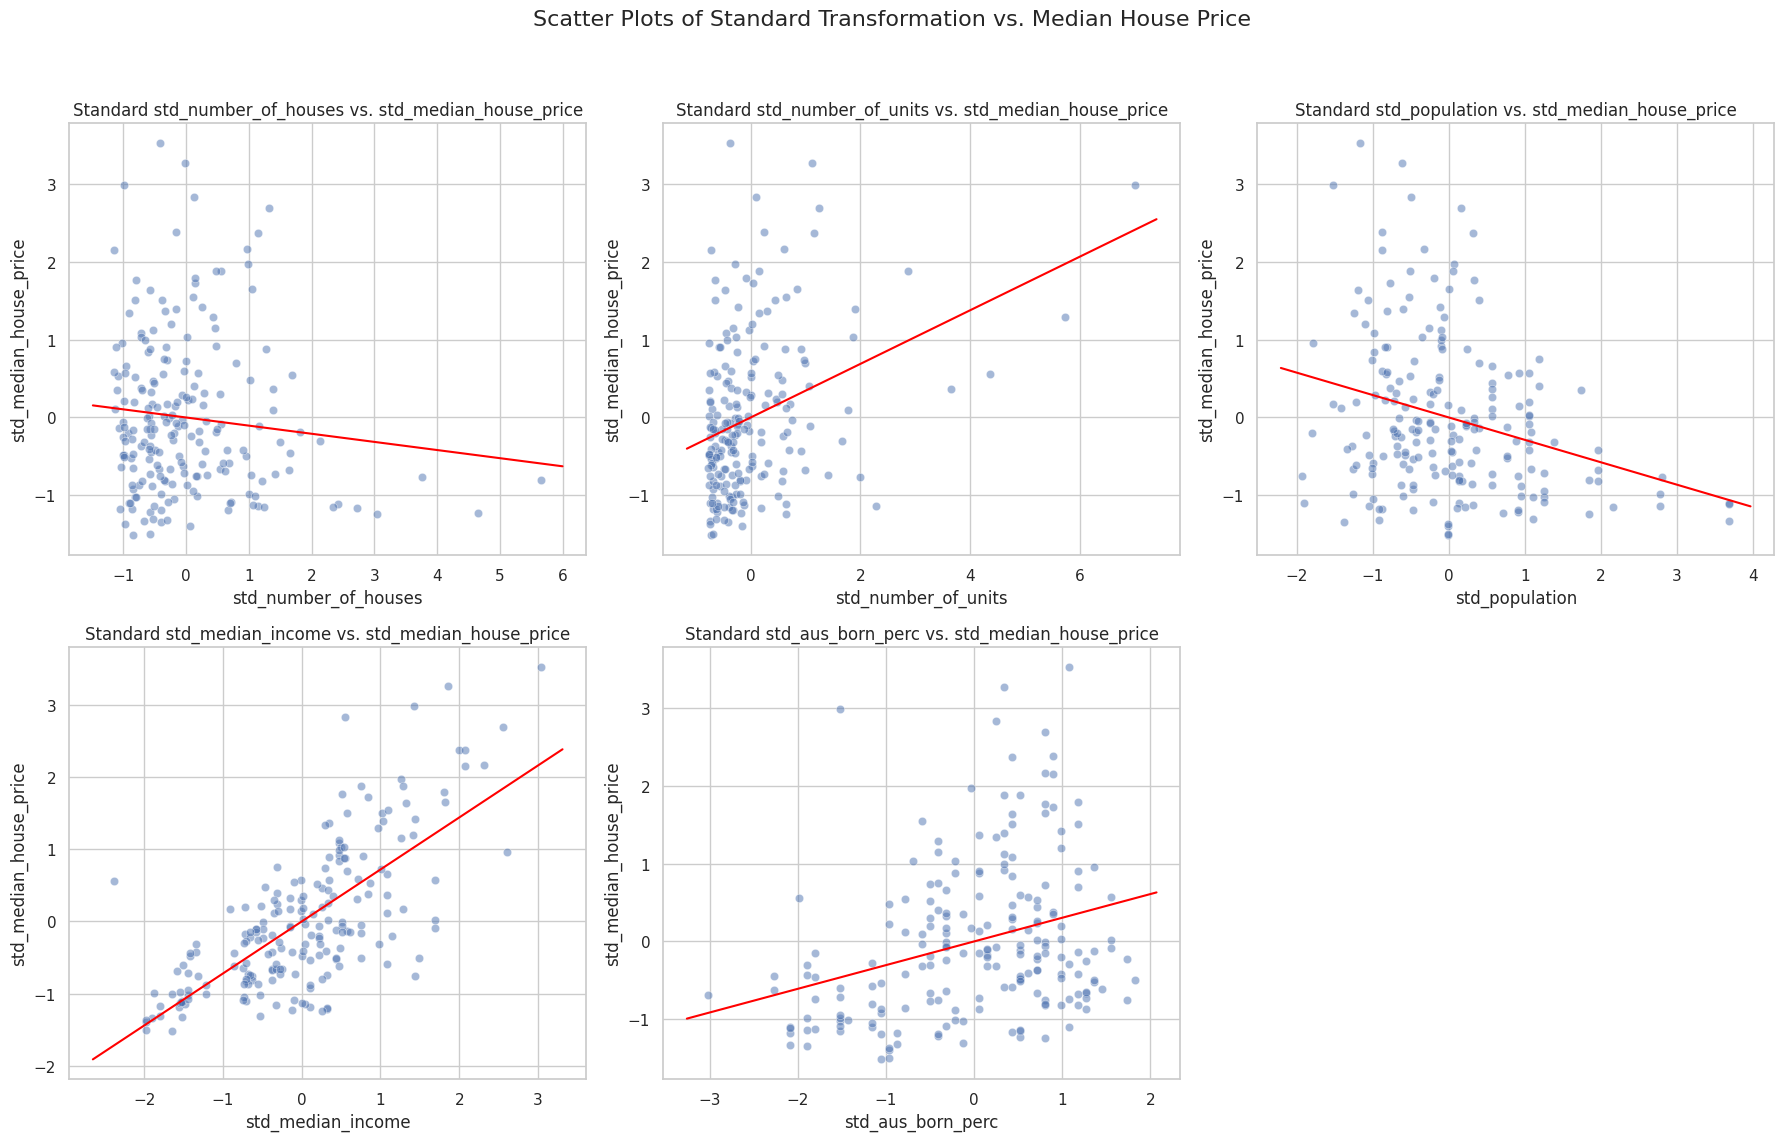

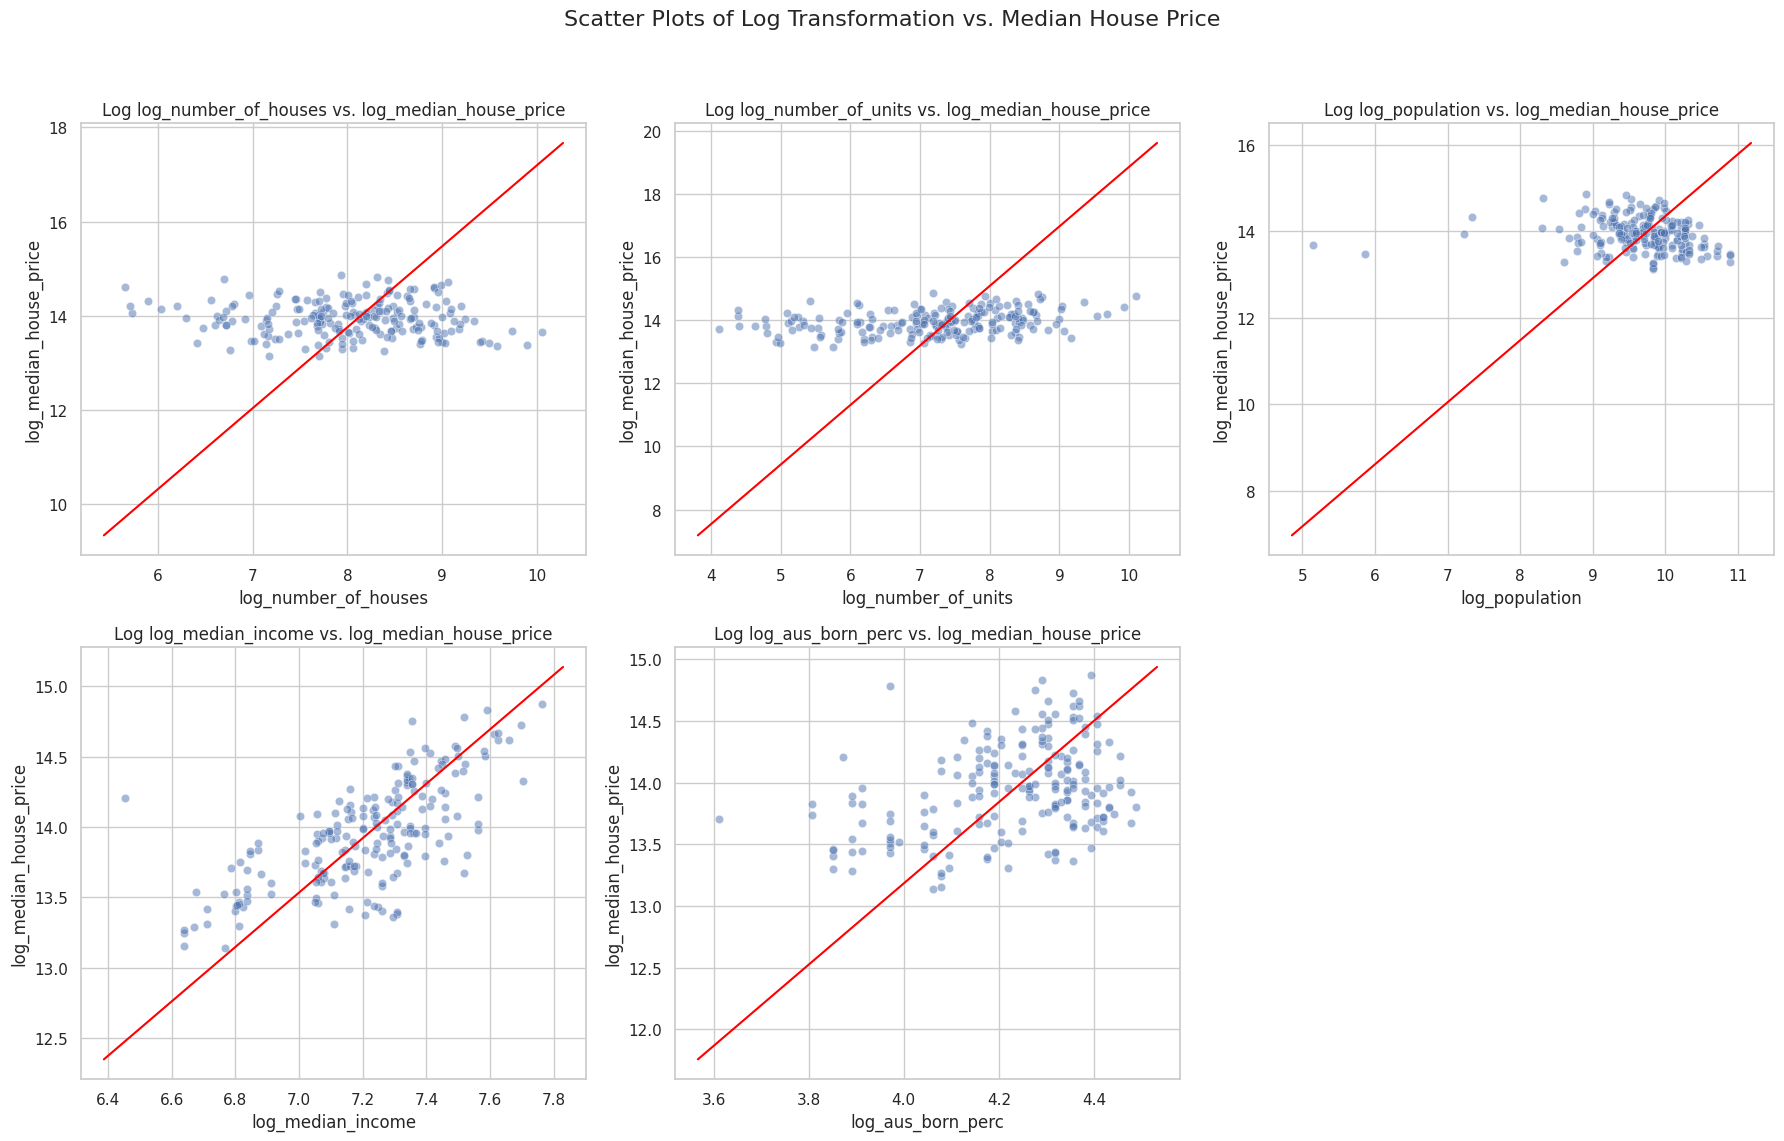

In [593]:

# List of transformation methods and their corresponding column names
transformations = {
    'BoxCox': ['boxcox_number_of_houses', 'boxcox_number_of_units', 'boxcox_population', 'boxcox_median_income', 'boxcox_aus_born_perc', 'boxcox_median_house_price'],
    'MinMax': ['minmax_number_of_houses', 'minmax_number_of_units', 'minmax_population', 'minmax_median_income', 'minmax_aus_born_perc', 'minmax_median_house_price'],
    'Power': ['power_number_of_houses', 'power_number_of_units', 'power_population', 'power_median_income', 'power_aus_born_perc', 'power_median_house_price'],
    'Standard': ['std_number_of_houses', 'std_number_of_units', 'std_population', 'std_median_income', 'std_aus_born_perc', 'std_median_house_price'],
    'Log': ['log_number_of_houses', 'log_number_of_units', 'log_population', 'log_median_income', 'log_aus_born_perc', 'log_median_house_price']
}

# Plotting all scatter plots in small batches
for trans_name, columns in transformations.items():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    fig.suptitle(f'Scatter Plots of {trans_name} Transformation vs. Median House Price', fontsize=16)

    for j, col in enumerate(columns[:-1]):  # Skip the last column (target variable)
        sns.scatterplot(x=suburb[col], y=suburb[columns[-1]], ax=axes[j//3, j%3], alpha=0.5)
        axes[j//3, j%3].set_title(f'{trans_name} {col} vs. {columns[-1]}')

        # Calculate the slope for the regression line passing through the origin
        slope = np.sum(suburb[col] * suburb[columns[-1]]) / np.sum(suburb[col] ** 2)
        x_vals = np.array(axes[j//3, j%3].get_xlim())
        y_vals = slope * x_vals
        axes[j//3, j%3].plot(x_vals, y_vals, color='red')

    # Hide the last empty subplot if any
    if len(columns[:-1]) < 6:
        for idx in range(len(columns[:-1]), 6):
            fig.delaxes(axes[idx//3, idx%3])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('all_scatter_plots.png')
    plt.show()



# **Observations:**

**Box-Cox Transformation:**

The Box-Cox transformation does not appear to have a substantial impact on enhancing linearity in the relationships. The data points exhibit a higher degree of clustering along the x-axis, suggesting that the transformation applied did not sufficiently disperse the data to effectively uncover any underlying relationships.

**Min-max Normalization:**

The Min-Max normalisation scales the data to the [0, 1] range while maintaining the original relationships. It is simpler to compare variables on the same scale when using this method because it preserves the basic patterns.

**Power Transformation:**

For some variables, the Power transformation exhibits a more scattered distribution but also adds some curvature. Although there is more unpredictability, the scatter plots still show some associations.

**Standardization:**

Standardisation, also known as z-score normalisation, centres the data around 0 with unit variation while preserving the overall patterns. The correlations are still evident but have been normalised, which facilitates comparisons between variables with various scales.

**Log Transformations:**

For the majority of variables, the linearity is significantly improved by the log transformation. Compared to the original and other transformations, the connections between the log-transformed median home price and the log-transformed predictors are more linear. This is particularly apparent when looking at population and median income data.

#**Conclusion:**


*   Linear Relationships - In terms of linearizing the correlations between the predictors and the median house price, the log transformation seems to be the most useful.

*   Spread of Data - Although some improvements were made, the linearity of the relationships was not much improved by the Power or Box-Cox transformations.


